# 统计学习导论第十八次作业
作业任务：__生成模型,MNIST数据集__   
作业任务1：自编码器[AE](#0)    
作业任务2：变分自编码器[VAE](#0.5)    
作业任务3：生成对抗网络[GAN](#1)    
作业任务4：GAN变体：深度卷积生成对抗网络[DCGAN](#2)    
作业任务5：Flow-based Model：[RealNVP](#3)    
作业任务6：扩散模型[Diffusion Model](#4)    
作业任务7：隐扩散模型[Latent Diffusion Model](#5)    
<center><span style="font-size: 1.5em;"><b>好难，坑有点深<b></span></center>

姓名：欧阳瑞志、班级：统计22、学号：220403102

## 一、数据导入
使用pytorch自带的MNIST手写数字数据  
样本量：60000
### 1.1 数据增强
增加数据多样性，扩大样本量，防止过拟合  
__随机旋转__:旋转角度范围是在-15度到15度  
__随机平移__:平移的比例是图像尺寸的 10%  
__随机裁剪__:裁剪区域的面积比例在原始图像的 80% 到 120% 之间  
因此三种变换加上原始数据，将数据从60000增加到240000

In [1]:
import time
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms,datasets
from torch.utils.data import DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt


# 用我macbook超绝cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定义基本的变换
base_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

# 定义随机旋转
transform1 = transforms.Compose([
    transforms.RandomRotation(15),
    base_transform
])

# 定义随机平移
transform2 = transforms.Compose([
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    base_transform
])

# 定义随机裁剪
transform3 = transforms.Compose([
    transforms.RandomResizedCrop(28, scale=(0.8, 1.2)),
    base_transform
])

# 设定原始数据集
mnist_data = torchvision.datasets.MNIST("./mnist_data", train=True, download=True, transform=base_transform)
print(f"原始数据集样本数量为: {len(mnist_data)}")

# 应用不同的增强变换
mnist_data_rotated = torchvision.datasets.MNIST("./mnist_data", train=True, download=True, transform=transform1)
mnist_data_translated = torchvision.datasets.MNIST("./mnist_data", train=True, download=True, transform=transform2)
mnist_data_cropped = torchvision.datasets.MNIST("./mnist_data", train=True, download=True, transform=transform3)

# 合并多个数据集
mnist_data = torch.utils.data.ConcatDataset([mnist_data, mnist_data_rotated, mnist_data_translated, mnist_data_cropped])

# 查看样本数量
print(f"数据增强后的数据集样本数量为: {len(mnist_data)}")

原始数据集样本数量为: 60000
数据增强后的数据集样本数量为: 240000


### 1.2 划分预训练数据
一方面是因为240000个数据进行调参实在太慢，太耗我CPU，因此将数据打乱取并采用简单随机抽样抽取1/100的预训练数据代表总体，使用与训练数据调参  
另一方面还能根据1/100的样本训练时间来调整我后续训练时长，对全样本训练所需时间有个把握

In [12]:
batch_size = 32

# 打乱顺序并只使用 1/100 的数据预训练
subset_size = len(mnist_data) // 100
indices = list(range(len(mnist_data)))
subset_indices = indices[:subset_size]

# 划分训练集、验证集和测试集的索引
train_size = int(0.8 * len(subset_indices))
val_size = int(0.1 * len(subset_indices))
test_size = len(subset_indices) - train_size - val_size
train_indices = subset_indices[:train_size]
val_indices = subset_indices[train_size:train_size + val_size]
test_indices = subset_indices[train_size + val_size:]

# 创建不同的采样器
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

# 数据加载器
train_loader = DataLoader(dataset=mnist_data, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset=mnist_data, batch_size=batch_size, sampler=val_sampler)
test_loader = DataLoader(dataset=mnist_data, batch_size=batch_size, sampler=test_sampler)

# 全部数据
subset_size = len(mnist_data) // 1
indices = list(range(len(mnist_data)))
subset_indices = indices[:subset_size]

# 划分训练集、验证集和测试集的索引
train_size = int(0.8 * len(subset_indices))
val_size = int(0.1 * len(subset_indices))
test_size = len(subset_indices) - train_size - val_size
train_indices = subset_indices[:train_size]
val_indices = subset_indices[train_size:train_size + val_size]
test_indices = subset_indices[train_size + val_size:]

# 创建不同的采样器
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

# 数据加载器
train_ = DataLoader(dataset=mnist_data, batch_size=batch_size, sampler=train_sampler)
val_ = DataLoader(dataset=mnist_data, batch_size=batch_size, sampler=val_sampler)
test_ = DataLoader(dataset=mnist_data, batch_size=batch_size, sampler=test_sampler)

<a id="0"></a>
## 二、Auto-encoder（AE）
### 2.1 小样本预训练与调参
调学习率：0.1，0.01，0.001

In [6]:
from torchvision.utils import save_image

class AE(nn.Module):
    def __init__(self):
        super().__init__()
        # 编码器
        self.encoder = nn.Sequential(nn.Linear(784, 256),
                                 nn.ReLU(),
                                 nn.Linear(256, 128),
                                 nn.ReLU(),
                                 nn.Linear(128, 10)
                                 )
        # 解码器
        self.decoder = nn.Sequential(nn.Linear(10, 128),
                                 nn.ReLU(),
                                 nn.Linear(128, 256),
                                 nn.ReLU(),
                                 nn.Linear(256, 784),
                                 )

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # [b,1,28,28] ———> [b,784]
        x = self.encoder(x)      # [b,784] ———> [b,10]
        x = self.decoder(x)      # [b,10] ———> [b,784]
        return x


def train(model, loss_fn, opt, epoch=50):
    for epoch in range(epoch):
        model.train()
        total_loss = 0.0
        for x, _ in trian_dl:
            x = x.to(device)
            y_pre = model(x)
            loss = loss_fn(y_pre, x.reshape(-1, 784))
            opt.zero_grad()
            loss.backward()
            opt.step()
            total_loss += loss
            break
        print(f'epoch = {epoch + 1}, train loss = {total_loss / len(trian_dl):.4f}')

    torch.save(model.state_dict(), 'ae_model.pth')


if __name__ == '__main__':

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 1、读取数据集
    trian_dl = train_loader

    # 2、创建AE模型及优化器
    model = AE().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=0.1)
    loss_fn = nn.MSELoss(reduction='mean')

    # 4、模型训练
    train(model, loss_fn, opt, epoch=50)

    # 5、模型推理
    # 加载模型
    model.load_state_dict(torch.load('ae_model.pth', map_location=device, weights_only=True))
    bs = 3
    text_dl = test_loader

    # 获取编码
    for x, y in text_dl:
        model.eval()
        save_image(x, "ae_original_image.png")
        x = x.to(device)
        sample_encoder = model.encoder(x.reshape(-1, 784))
        print(sample_encoder)

        image_encoder = model.decoder(sample_encoder).reshape(-1, 1, 28, 28)
        save_image(image_encoder, "ae_image_encoder.png")

        sample_sum = torch.sum(sample_encoder, dim=0) / 2
        sample = sample_sum.tile(bs, 1)
        image = model.decoder(sample).reshape(-1, 1, 28, 28)

        save_image(image, "ae_image.png")
        break

print('------------------------------------------------lr = 0.1 done------------------------------------------------')


if __name__ == '__main__':

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 1、读取数据集
    trian_dl = train_loader

    # 2、创建AE模型及优化器
    model = AE().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.MSELoss(reduction='mean')

    # 4、模型训练
    train(model, loss_fn, opt, epoch=50)

    # 5、模型推理
    # 加载模型
    model.load_state_dict(torch.load('ae_model.pth', map_location=device, weights_only=True))
    bs = 3
    text_dl = test_loader

    # 获取编码
    for x, y in text_dl:
        model.eval()
        save_image(x, "ae_original_image.png")
        x = x.to(device)
        sample_encoder = model.encoder(x.reshape(-1, 784))
        print(sample_encoder)

        image_encoder = model.decoder(sample_encoder).reshape(-1, 1, 28, 28)
        save_image(image_encoder, "ae_image_encoder.png")

        sample_sum = torch.sum(sample_encoder, dim=0) / 2
        sample = sample_sum.tile(bs, 1)
        image = model.decoder(sample).reshape(-1, 1, 28, 28)

        save_image(image, "ae_image.png")
        break

print('------------------------------------------------lr = 0.01 done------------------------------------------------')


if __name__ == '__main__':

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 1、读取数据集
    trian_dl = train_loader

    # 2、创建AE模型及优化器
    model = AE().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss(reduction='mean')

    # 4、模型训练
    train(model, loss_fn, opt, epoch=50)

    # 5、模型推理
    # 加载模型
    model.load_state_dict(torch.load('ae_model.pth', map_location=device, weights_only=True))
    bs = 3
    text_dl = test_loader

    # 获取编码
    for x, y in text_dl:
        model.eval()
        save_image(x, "ae_original_image.png")
        x = x.to(device)
        sample_encoder = model.encoder(x.reshape(-1, 784))
        print(sample_encoder)

        image_encoder = model.decoder(sample_encoder).reshape(-1, 1, 28, 28)
        save_image(image_encoder, "ae_image_encoder.png")

        sample_sum = torch.sum(sample_encoder, dim=0) / 2
        sample = sample_sum.tile(bs, 1)
        image = model.decoder(sample).reshape(-1, 1, 28, 28)

        save_image(image, "ae_image.png")
        break

print('------------------------------------------------lr = 0.001 done------------------------------------------------')

epoch = 1, train loss = 0.0154
epoch = 2, train loss = 12388388.0000
epoch = 3, train loss = 70.4851
epoch = 4, train loss = 106.7381
epoch = 5, train loss = 25265.4688
epoch = 6, train loss = 18.5979
epoch = 7, train loss = 1892.0757
epoch = 8, train loss = 170.2853
epoch = 9, train loss = 15866.5186
epoch = 10, train loss = 2852.8777
epoch = 11, train loss = 137.6414
epoch = 12, train loss = 1792.6683
epoch = 13, train loss = 3015.3210
epoch = 14, train loss = 2702.2979
epoch = 15, train loss = 2401.8867
epoch = 16, train loss = 3488.3103
epoch = 17, train loss = 31.4047
epoch = 18, train loss = 2140.2688
epoch = 19, train loss = 704.5426
epoch = 20, train loss = 1030.7477
epoch = 21, train loss = 484.0074
epoch = 22, train loss = 143.7693
epoch = 23, train loss = 362.6602
epoch = 24, train loss = 79.9352
epoch = 25, train loss = 11.0017
epoch = 26, train loss = 14.7938
epoch = 27, train loss = 0.7407
epoch = 28, train loss = 0.6133
epoch = 29, train loss = 0.4273
epoch = 30, train l

__学习率确定为0.001__
### 2.2 全样本训练

epoch = 1, train loss = 0.0002
epoch = 2, train loss = 0.0002
epoch = 3, train loss = 0.0001
epoch = 4, train loss = 0.0001
epoch = 5, train loss = 0.0001
epoch = 6, train loss = 0.0001
epoch = 7, train loss = 0.0001
epoch = 8, train loss = 0.0001
epoch = 9, train loss = 0.0001
epoch = 10, train loss = 0.0001
epoch = 11, train loss = 0.0001
epoch = 12, train loss = 0.0001
epoch = 13, train loss = 0.0001
epoch = 14, train loss = 0.0000
epoch = 15, train loss = 0.0000
epoch = 16, train loss = 0.0001
epoch = 17, train loss = 0.0001
epoch = 18, train loss = 0.0000
epoch = 19, train loss = 0.0000
epoch = 20, train loss = 0.0001
epoch = 21, train loss = 0.0001
epoch = 22, train loss = 0.0000
epoch = 23, train loss = 0.0000
epoch = 24, train loss = 0.0000
epoch = 25, train loss = 0.0000
epoch = 26, train loss = 0.0000
epoch = 27, train loss = 0.0001
epoch = 28, train loss = 0.0000
epoch = 29, train loss = 0.0000
epoch = 30, train loss = 0.0000
epoch = 31, train loss = 0.0000
epoch = 32, train

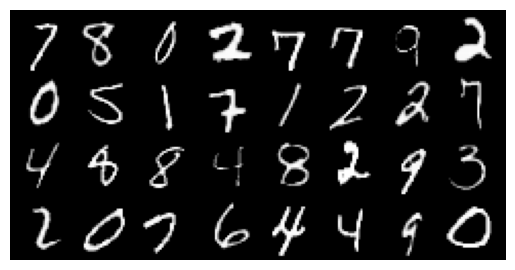

经过自编码器的编码和解码部分处理后的图像：


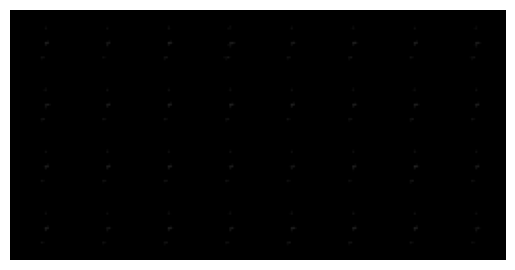

平均化处理后的图像：


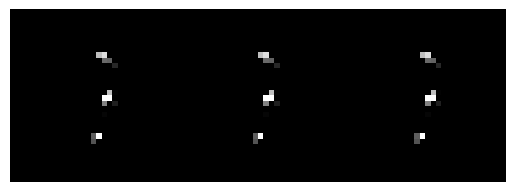

In [14]:
if __name__ == '__main__':

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 1、读取数据集
    trian_dl = train_

    # 2、创建AE模型及优化器
    model = AE().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss(reduction='mean')

    # 4、模型训练
    train(model, loss_fn, opt, epoch=50)

    # 5、模型推理
    # 加载模型
    model.load_state_dict(torch.load('ae_model.pth', map_location=device, weights_only=True))
    bs = 3
    text_dl = test_

    # 获取编码
    for x, y in text_dl:
        model.eval()
        save_image(x, "ae_original_image.png")
        x = x.to(device)
        sample_encoder = model.encoder(x.reshape(-1, 784))
        print(sample_encoder)

        image_encoder = model.decoder(sample_encoder).reshape(-1, 1, 28, 28)
        save_image(image_encoder, "ae_image_encoder.png")

        sample_sum = torch.sum(sample_encoder, dim=0) / 2
        sample = sample_sum.tile(bs, 1)
        image = model.decoder(sample).reshape(-1, 1, 28, 28)

        save_image(image, "ae_image.png")
        break

import matplotlib.pyplot as plt
print('原始图像如下：')
train_hist_img_path = 'ae_original_image.png'
train_hist_img = plt.imread(train_hist_img_path)
plt.imshow(train_hist_img)
plt.axis('off')
plt.show()

print('经过自编码器的编码和解码部分处理后的图像：')
train_hist_img_path = 'ae_image_encoder.png'
train_hist_img = plt.imread(train_hist_img_path)
plt.imshow(train_hist_img)
plt.axis('off')
plt.show()

print('平均化处理后的图像：')
train_hist_img_path = 'ae_image.png'
train_hist_img = plt.imread(train_hist_img_path)
plt.imshow(train_hist_img)
plt.axis('off')
plt.show()

__效果怎么这么差。。。__

<a id="0.5"></a>
## 三、变分自编码器(VAE)
### 3.1 模型训练

In [28]:
from torchvision.utils import make_grid
import torch.optim as optim

# 定义VAE模型
class VAE(nn.Module):

    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        # 编码器部分
        self.encoder = nn.Sequential(
            nn.Linear(784, 400),
            nn.ReLU(),
            nn.Linear(400, 2 * latent_dim)  # 输出均值和对数方差
        )
        # 解码器部分
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 784),
            nn.Sigmoid()  # 将输出值约束到0-1之间
        )
        self.latent_dim = latent_dim

    def encode(self, x):
        h = self.encoder(x)
        mu, log_var = h.chunk(2, dim=-1)  # 分割成均值和对数方差
        return mu, log_var

    # 重参数化
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    # 前向传播
    def forward(self, x):
        mu, log_var = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var


# 定义VAE的损失函数
def vae_loss(recon_x, x, mu, log_var):
    # 重构损失：二元交叉熵
    recon_loss = nn.functional.binary_cross_entropy(recon_x,
                                                    x.view(-1, 784),
                                                    reduction='sum')
    # KL 散度
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + kl_divergence


# 数据加载
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data',
                               train=True,
                               transform=transform,
                               download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# 初始化模型和优化器
latent_dim = 20
vae = VAE(latent_dim=latent_dim).to('cpu')
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# 训练VAE模型，这里训练200轮
epochs = 200
vae.train()
for epoch in range(epochs):
    train_loss = 0
    for x, _ in train_loader:
        x = x.to('cpu')
        optimizer.zero_grad()
        recon_x, mu, log_var = vae(x)
        loss = vae_loss(recon_x, x, mu, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f"Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset):.4f}")


# 保存模型
torch.save(vae.state_dict(), 'vae_gen_mnist_image.pth')

Epoch 1, Loss: 164.9832
Epoch 2, Loss: 121.8396
Epoch 3, Loss: 114.7761
Epoch 4, Loss: 111.7655
Epoch 5, Loss: 109.9577
Epoch 6, Loss: 108.7421
Epoch 7, Loss: 107.9010
Epoch 8, Loss: 107.2866
Epoch 9, Loss: 106.7004
Epoch 10, Loss: 106.3287
Epoch 11, Loss: 105.9103
Epoch 12, Loss: 105.6256
Epoch 13, Loss: 105.3726
Epoch 14, Loss: 105.1205
Epoch 15, Loss: 104.8947
Epoch 16, Loss: 104.6637
Epoch 17, Loss: 104.4515
Epoch 18, Loss: 104.3215
Epoch 19, Loss: 104.2078
Epoch 20, Loss: 104.0211
Epoch 21, Loss: 103.9375
Epoch 22, Loss: 103.7521
Epoch 23, Loss: 103.6372
Epoch 24, Loss: 103.5245
Epoch 25, Loss: 103.4463
Epoch 26, Loss: 103.3522
Epoch 27, Loss: 103.2212
Epoch 28, Loss: 103.0952
Epoch 29, Loss: 103.0732
Epoch 30, Loss: 102.9583
Epoch 31, Loss: 102.8873
Epoch 32, Loss: 102.8003
Epoch 33, Loss: 102.6871
Epoch 34, Loss: 102.6738
Epoch 35, Loss: 102.5867
Epoch 36, Loss: 102.5340
Epoch 37, Loss: 102.4730
Epoch 38, Loss: 102.4113
Epoch 39, Loss: 102.3539
Epoch 40, Loss: 102.2580
Epoch 41,

### 3.2模型应用（生成图像）
使用训练好的VAE模型，给定随机噪声，来生成图像，看看模型训练效果

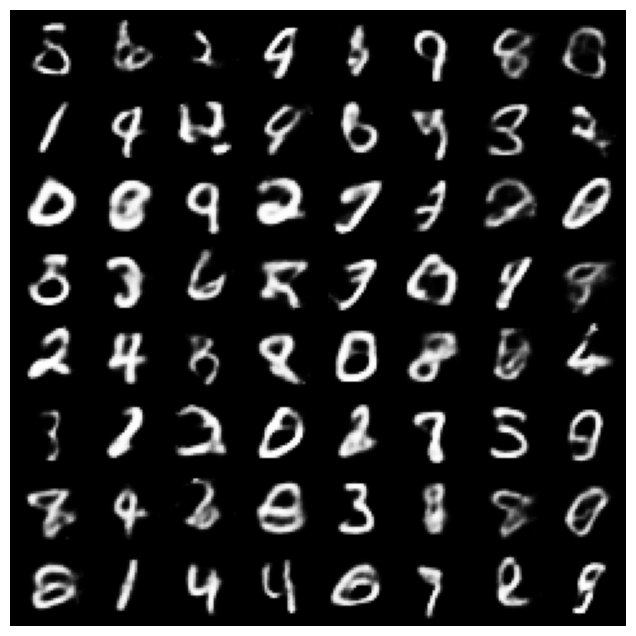

In [29]:
# 生成图像
vae.eval()
with torch.no_grad():
    z = torch.randn(64, latent_dim).to('cpu')  # 生成64个随机latent向量
    generated_images = vae.decode(z).cpu()
    generated_images = generated_images.view(-1, 1, 28, 28)  # 调整维度适应MNIST格式

    # 可视化生成的图像
    grid = make_grid(generated_images, nrow=8, padding=2, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    # plt.show()
    plt.savefig('gen_mnist.png', dpi=800)

__相比AE，VAE效果好了很多，但loss还是很高，上GAN吧__

<a id="1"></a>
## 四、GAN
### 4.1 生成器和判别器
有全连接神经网络和卷积神经网络，在此先尝试全链接、稍后使用DCGAN对比

In [6]:
image_size = 784
hidden_size = 256

# 定义生成器类
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, image_size),
            nn.Tanh()  # 转换至（-1，1）
        )

    def forward(self, x):
        return self.main(x)


# 定义判别器类
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(image_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),  # 增加 Dropout 防止过拟合
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),  # 增加 Dropout 防止过拟合
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()  # sigmoid 结果为（0，1）
        )

    def forward(self, x):
        return self.main(x)


# Generator
latent_size = 64  # latent_size，相当于初始噪声的维数


# 实例化生成器和判别器
G = Generator().to(device)
D = Discriminator().to(device)

### 4.2 定义损失函数、优化器、学习率
调参发现学习率越小越好，但不敢再小了

In [7]:
# 定义损失函数、优化器、学习率
loss_fn = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

### 4.3 优化生成器、判别器

In [8]:
# 先定义一个梯度清零的函数，方便后续使用
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()


# 迭代次数与计时
num_epochs = 200
start = time.perf_counter()  # 开始时间


def train_discriminator(real_images, batch_size):
    # 定义真假 label，用作评分
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # 第一部分，D 对真图的判断能力
    outputs = D(real_images)  # 将真图送入 D，输出（0，1），应该是越接近 1 越好
    d_loss_real = loss_fn(outputs, real_labels)
    real_score = outputs  # 真图的分数，越大越好

    # 第二部分，D 对假图的判断能力
    z = torch.randn(batch_size, latent_size).to(device)  # 开始生成一组 fake images 即 32*784 的噪声经过 G 的假图
    fake_images = G(z)
    outputs = D(fake_images.detach())  # 将假图片给 D，detach 表示不作用于求 grad
    d_loss_fake = loss_fn(outputs, fake_labels)
    fake_score = outputs  # 假图的分数，越小越好

    # 开始优化 discriminator
    d_loss = d_loss_real + d_loss_fake  # 总的损失就是以上两部分相加，越小越好
    reset_grad()
    d_loss.backward()
    d_optimizer.step()
    return d_loss, real_score, fake_score


def train_generator(batch_size, real_labels):
    # 可以用前面的 z，也可以新生成，因为模型没有改变，事实上是一样的
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    g_loss = loss_fn(outputs, real_labels)  # G 想骗过 D，故让其越接近 1 越好

    # 开始优化 generator
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss

### 4.4 模型训练

Epoch [0/200], Step [0/60], d_loss: 1.3502, g_loss: 0.7100, D(x): 0.51, D(G(z)): 0.49
Epoch [1/200], Step [0/60], d_loss: 1.2630, g_loss: 0.6175, D(x): 0.72, D(G(z)): 0.60
Epoch [2/200], Step [0/60], d_loss: 0.4653, g_loss: 1.8606, D(x): 0.91, D(G(z)): 0.30
Epoch [3/200], Step [0/60], d_loss: 0.0586, g_loss: 4.4687, D(x): 0.99, D(G(z)): 0.05
Epoch [4/200], Step [0/60], d_loss: 0.2690, g_loss: 3.1316, D(x): 0.86, D(G(z)): 0.09
Epoch [5/200], Step [0/60], d_loss: 0.4469, g_loss: 2.1383, D(x): 0.80, D(G(z)): 0.16
Epoch [6/200], Step [0/60], d_loss: 0.4045, g_loss: 2.8474, D(x): 0.83, D(G(z)): 0.15
Epoch [7/200], Step [0/60], d_loss: 0.0958, g_loss: 3.9507, D(x): 0.96, D(G(z)): 0.05
Epoch [8/200], Step [0/60], d_loss: 0.6859, g_loss: 1.7262, D(x): 0.84, D(G(z)): 0.34
Epoch [9/200], Step [0/60], d_loss: 0.3789, g_loss: 2.2833, D(x): 0.93, D(G(z)): 0.24
Epoch [10/200], Step [0/60], d_loss: 0.0981, g_loss: 4.7183, D(x): 0.95, D(G(z)): 0.04
Epoch [11/200], Step [0/60], d_loss: 0.7607, g_loss: 

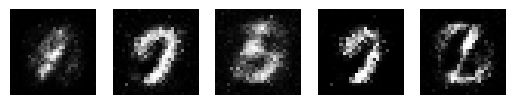

Epoch [100/200], Step [0/60], d_loss: 0.7663, g_loss: 1.1100, D(x): 0.75, D(G(z)): 0.30
Epoch [101/200], Step [0/60], d_loss: 0.7696, g_loss: 1.1967, D(x): 0.77, D(G(z)): 0.35
Epoch [102/200], Step [0/60], d_loss: 1.0207, g_loss: 1.4537, D(x): 0.65, D(G(z)): 0.31
Epoch [103/200], Step [0/60], d_loss: 0.8954, g_loss: 2.4313, D(x): 0.64, D(G(z)): 0.23
Epoch [104/200], Step [0/60], d_loss: 0.7066, g_loss: 1.5712, D(x): 0.75, D(G(z)): 0.26
Epoch [105/200], Step [0/60], d_loss: 0.8293, g_loss: 1.2842, D(x): 0.65, D(G(z)): 0.27
Epoch [106/200], Step [0/60], d_loss: 0.8347, g_loss: 1.6580, D(x): 0.73, D(G(z)): 0.31
Epoch [107/200], Step [0/60], d_loss: 1.1684, g_loss: 0.9457, D(x): 0.74, D(G(z)): 0.49
Epoch [108/200], Step [0/60], d_loss: 1.1125, g_loss: 1.5141, D(x): 0.55, D(G(z)): 0.26
Epoch [109/200], Step [0/60], d_loss: 1.0728, g_loss: 1.3384, D(x): 0.60, D(G(z)): 0.33
Epoch [110/200], Step [0/60], d_loss: 0.8566, g_loss: 1.4306, D(x): 0.73, D(G(z)): 0.34
Epoch [111/200], Step [0/60], d_

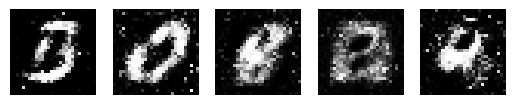

利用 GPU 总用时：0.00 分钟 40.46 秒


In [9]:
# 存储不同的指标
d_losses = []
g_losses = []
real_scores = []
fake_scores = []


def display_images(generator, num_images=1):
    z = torch.randn(num_images, latent_size).to(device)
    fake_images = generator(z).view(num_images, 28, 28).data.cpu().numpy()
    fig, axs = plt.subplots(1, num_images)
    for i in range(num_images):
        axs[i].imshow(fake_images[i], cmap=plt.cm.gray)
        axs[i].axis('off')
    plt.show()


# 开始训练
for epoch in range(num_epochs):
    # 训练过程
    G.train()
    D.train()
    for i, (images, _) in enumerate(train_loader):  # 当前 step
        batch_size = images.size(0)  # 变成一维向量
        images = images.reshape(batch_size, image_size).to(device)

        d_loss, real_score, fake_score = train_discriminator(images, batch_size)
        real_labels = torch.ones(batch_size, 1).to(device)  # 生成 real_labels
        g_loss = train_generator(batch_size, real_labels)

        # 存储不同指标
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        real_scores.append(real_score.mean().item())
        fake_scores.append(fake_score.mean().item())

        # 优化完成，下面进行一些反馈，展示学习进度
        if i % 100 == 0:
            print("Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}"
                 .format(epoch, num_epochs, i, len(train_loader), d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()))
        # 每隔一定的 epoch 展示生成的图像
        if (epoch + 1) % 100 == 0 and i == 0:
            display_images(G, 5)


# 训练结束，跳出循环，检验成果
end = time.perf_counter()  # 结束时间
total = end - start
minutes = total // 60
seconds = total - minutes * 60
print("利用 GPU 总用时：{:.2f} 分钟 {:.2f} 秒".format(minutes, seconds))

### 4.5 损失曲线

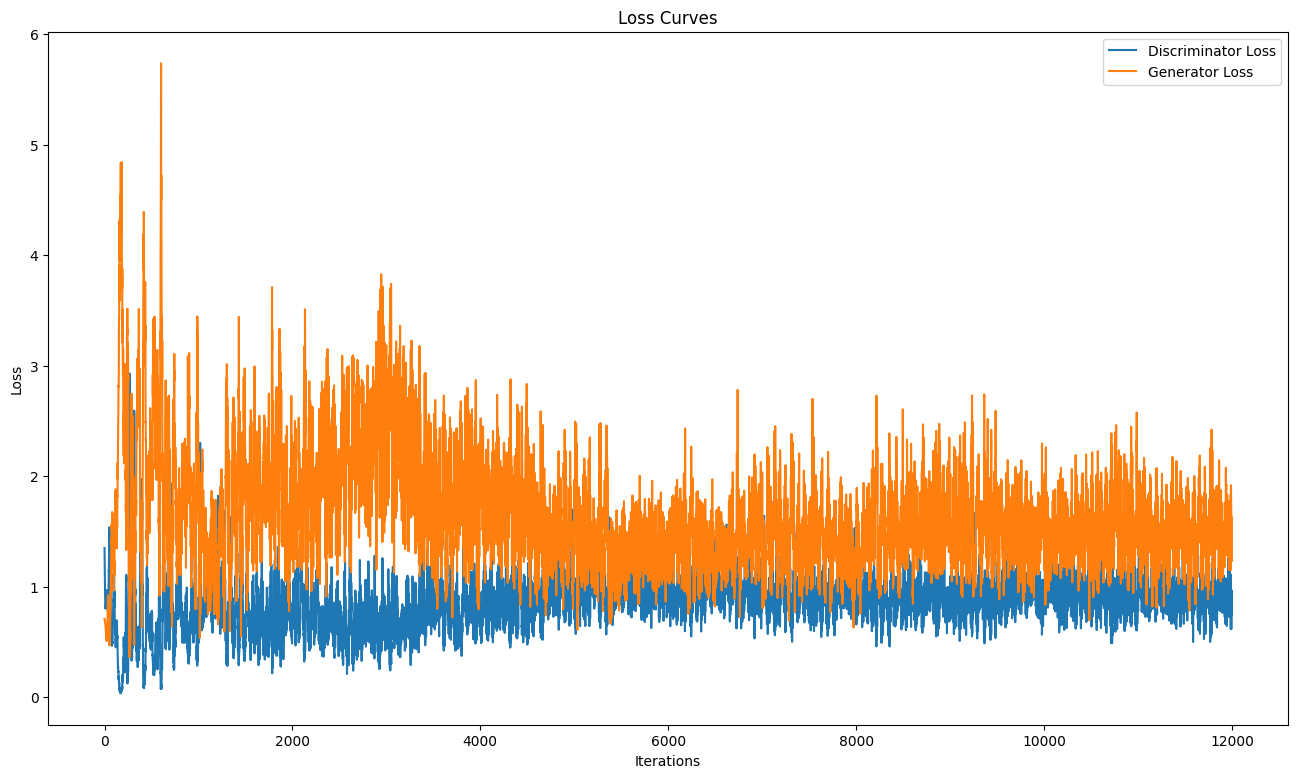

In [10]:
# 绘制损失曲线
plt.figure(figsize=(16, 9))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.savefig(fname="Loss Curves.png")

### 4.6 得分曲线

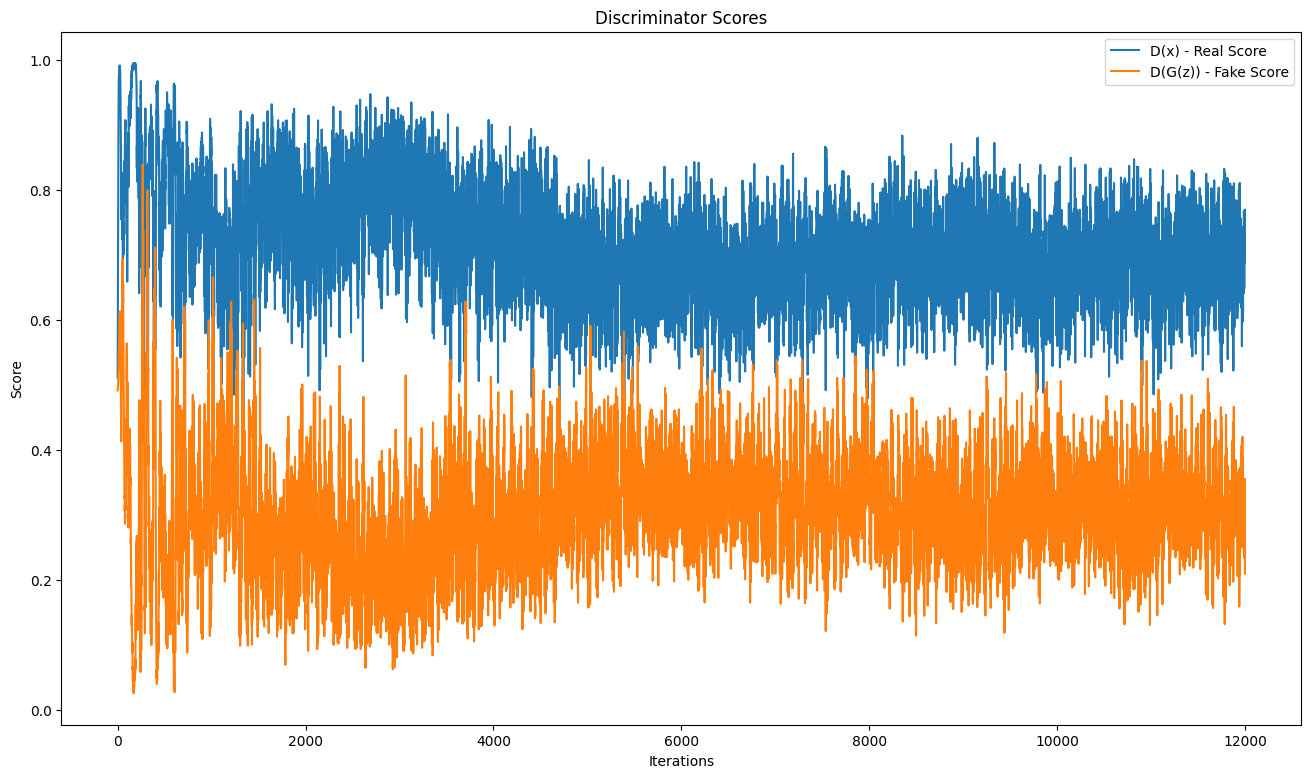

In [11]:
# 绘制判别器对真实数据和生成数据的评分曲线
plt.figure(figsize=(16, 9))
plt.plot(real_scores, label='D(x) - Real Score')
plt.plot(fake_scores, label='D(G(z)) - Fake Score')
plt.xlabel('Iterations')
plt.ylabel('Score')
plt.legend()
plt.title('Discriminator Scores')
plt.savefig(fname="Discriminator Scores.png")

### 4.7 测试集情况

In [12]:
# 测试过程
G.eval()
D.eval()
test_d_losses = []
test_g_losses = []
with torch.no_grad():
    for images, _ in test_loader:
        batch_size = images.size(0)
        images = images.reshape(batch_size, image_size).to(device)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # 测试判别器
        outputs = D(images)
        test_d_loss_real = loss_fn(outputs, real_labels)
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images.detach())
        test_d_loss_fake = loss_fn(outputs, fake_labels)
        test_d_loss = test_d_loss_real + test_d_loss_fake
        test_d_losses.append(test_d_loss.item())

        # 测试生成器
        outputs = D(fake_images)
        test_g_loss = loss_fn(outputs, real_labels)
        test_g_losses.append(test_g_loss.item())

test_d_loss_mean = sum(test_d_losses) / len(test_d_losses)
test_g_loss_mean = sum(test_g_losses) / len(test_g_losses)
print(f"Test D Loss: {test_d_loss_mean:.4f}, Test G Loss: {test_g_loss_mean:.4f}")

Test D Loss: 0.6753, Test G Loss: 1.6819


### 4.8 全样本训练

Epoch [0/20], Step [0/6000], d_loss: 1.0211, g_loss: 1.1392, D(x): 0.61, D(G(z)): 0.29
Epoch [0/20], Step [100/6000], d_loss: 0.9631, g_loss: 1.4575, D(x): 0.72, D(G(z)): 0.34
Epoch [0/20], Step [200/6000], d_loss: 0.8167, g_loss: 1.3128, D(x): 0.66, D(G(z)): 0.23
Epoch [0/20], Step [300/6000], d_loss: 1.0349, g_loss: 1.4134, D(x): 0.63, D(G(z)): 0.34
Epoch [0/20], Step [400/6000], d_loss: 0.9177, g_loss: 1.2358, D(x): 0.75, D(G(z)): 0.41
Epoch [0/20], Step [500/6000], d_loss: 0.9120, g_loss: 1.7142, D(x): 0.70, D(G(z)): 0.28
Epoch [0/20], Step [600/6000], d_loss: 0.8616, g_loss: 1.2967, D(x): 0.70, D(G(z)): 0.29
Epoch [0/20], Step [700/6000], d_loss: 0.9313, g_loss: 1.4197, D(x): 0.74, D(G(z)): 0.35
Epoch [0/20], Step [800/6000], d_loss: 0.8299, g_loss: 1.2797, D(x): 0.77, D(G(z)): 0.32
Epoch [0/20], Step [900/6000], d_loss: 0.9060, g_loss: 1.1742, D(x): 0.75, D(G(z)): 0.37
Epoch [0/20], Step [1000/6000], d_loss: 1.2460, g_loss: 1.5892, D(x): 0.73, D(G(z)): 0.46
Epoch [0/20], Step [11

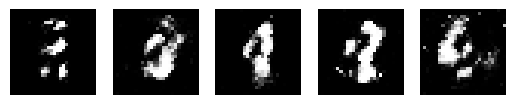

Epoch [1/20], Step [100/6000], d_loss: 0.6304, g_loss: 1.7844, D(x): 0.79, D(G(z)): 0.27
Epoch [1/20], Step [200/6000], d_loss: 1.0241, g_loss: 1.4903, D(x): 0.67, D(G(z)): 0.35
Epoch [1/20], Step [300/6000], d_loss: 0.9528, g_loss: 1.4212, D(x): 0.75, D(G(z)): 0.36
Epoch [1/20], Step [400/6000], d_loss: 0.9175, g_loss: 1.5172, D(x): 0.69, D(G(z)): 0.31
Epoch [1/20], Step [500/6000], d_loss: 0.7183, g_loss: 2.0390, D(x): 0.76, D(G(z)): 0.25
Epoch [1/20], Step [600/6000], d_loss: 1.0459, g_loss: 1.3159, D(x): 0.67, D(G(z)): 0.33
Epoch [1/20], Step [700/6000], d_loss: 0.8715, g_loss: 1.5335, D(x): 0.69, D(G(z)): 0.27
Epoch [1/20], Step [800/6000], d_loss: 0.7872, g_loss: 1.7216, D(x): 0.73, D(G(z)): 0.26
Epoch [1/20], Step [900/6000], d_loss: 0.8324, g_loss: 1.7894, D(x): 0.67, D(G(z)): 0.22
Epoch [1/20], Step [1000/6000], d_loss: 1.0087, g_loss: 1.7499, D(x): 0.70, D(G(z)): 0.30
Epoch [1/20], Step [1100/6000], d_loss: 0.9412, g_loss: 1.6147, D(x): 0.65, D(G(z)): 0.23
Epoch [1/20], Step 

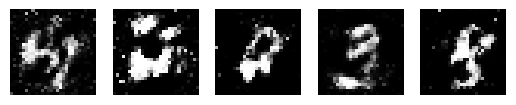

Epoch [3/20], Step [100/6000], d_loss: 1.3210, g_loss: 0.9453, D(x): 0.56, D(G(z)): 0.39
Epoch [3/20], Step [200/6000], d_loss: 0.8571, g_loss: 1.3478, D(x): 0.74, D(G(z)): 0.35
Epoch [3/20], Step [300/6000], d_loss: 0.9232, g_loss: 1.4775, D(x): 0.72, D(G(z)): 0.34
Epoch [3/20], Step [400/6000], d_loss: 0.9323, g_loss: 1.1471, D(x): 0.70, D(G(z)): 0.31
Epoch [3/20], Step [500/6000], d_loss: 0.8995, g_loss: 1.6271, D(x): 0.68, D(G(z)): 0.28
Epoch [3/20], Step [600/6000], d_loss: 0.9052, g_loss: 1.1729, D(x): 0.77, D(G(z)): 0.38
Epoch [3/20], Step [700/6000], d_loss: 0.9661, g_loss: 0.8627, D(x): 0.70, D(G(z)): 0.35
Epoch [3/20], Step [800/6000], d_loss: 0.9469, g_loss: 1.3518, D(x): 0.70, D(G(z)): 0.33
Epoch [3/20], Step [900/6000], d_loss: 0.8680, g_loss: 1.1365, D(x): 0.69, D(G(z)): 0.29
Epoch [3/20], Step [1000/6000], d_loss: 1.2419, g_loss: 1.2249, D(x): 0.70, D(G(z)): 0.46
Epoch [3/20], Step [1100/6000], d_loss: 1.2106, g_loss: 1.3913, D(x): 0.56, D(G(z)): 0.34
Epoch [3/20], Step 

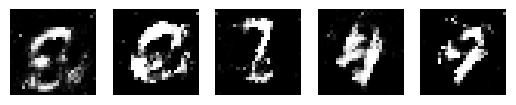

Epoch [5/20], Step [100/6000], d_loss: 1.0417, g_loss: 1.4800, D(x): 0.53, D(G(z)): 0.21
Epoch [5/20], Step [200/6000], d_loss: 1.2480, g_loss: 1.0629, D(x): 0.57, D(G(z)): 0.37
Epoch [5/20], Step [300/6000], d_loss: 0.9041, g_loss: 1.1857, D(x): 0.63, D(G(z)): 0.27
Epoch [5/20], Step [400/6000], d_loss: 1.0048, g_loss: 1.1517, D(x): 0.69, D(G(z)): 0.40
Epoch [5/20], Step [500/6000], d_loss: 1.1052, g_loss: 1.0941, D(x): 0.64, D(G(z)): 0.41
Epoch [5/20], Step [600/6000], d_loss: 1.2404, g_loss: 1.2579, D(x): 0.62, D(G(z)): 0.42
Epoch [5/20], Step [700/6000], d_loss: 1.1359, g_loss: 1.2869, D(x): 0.63, D(G(z)): 0.39
Epoch [5/20], Step [800/6000], d_loss: 1.0492, g_loss: 1.1692, D(x): 0.68, D(G(z)): 0.37
Epoch [5/20], Step [900/6000], d_loss: 1.0816, g_loss: 1.0360, D(x): 0.65, D(G(z)): 0.40
Epoch [5/20], Step [1000/6000], d_loss: 0.9411, g_loss: 1.1878, D(x): 0.71, D(G(z)): 0.36
Epoch [5/20], Step [1100/6000], d_loss: 1.0585, g_loss: 1.2257, D(x): 0.64, D(G(z)): 0.36
Epoch [5/20], Step 

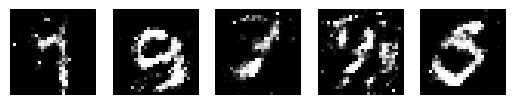

Epoch [7/20], Step [100/6000], d_loss: 1.0483, g_loss: 1.0022, D(x): 0.63, D(G(z)): 0.37
Epoch [7/20], Step [200/6000], d_loss: 1.0087, g_loss: 1.0237, D(x): 0.65, D(G(z)): 0.37
Epoch [7/20], Step [300/6000], d_loss: 1.1613, g_loss: 0.8894, D(x): 0.60, D(G(z)): 0.40
Epoch [7/20], Step [400/6000], d_loss: 1.1436, g_loss: 1.1634, D(x): 0.60, D(G(z)): 0.41
Epoch [7/20], Step [500/6000], d_loss: 1.4295, g_loss: 0.9650, D(x): 0.56, D(G(z)): 0.42
Epoch [7/20], Step [600/6000], d_loss: 1.1142, g_loss: 0.9668, D(x): 0.59, D(G(z)): 0.38
Epoch [7/20], Step [700/6000], d_loss: 1.0778, g_loss: 0.9376, D(x): 0.67, D(G(z)): 0.40
Epoch [7/20], Step [800/6000], d_loss: 1.0678, g_loss: 1.1220, D(x): 0.66, D(G(z)): 0.40
Epoch [7/20], Step [900/6000], d_loss: 1.0301, g_loss: 1.1057, D(x): 0.61, D(G(z)): 0.32
Epoch [7/20], Step [1000/6000], d_loss: 1.1883, g_loss: 0.9061, D(x): 0.60, D(G(z)): 0.40
Epoch [7/20], Step [1100/6000], d_loss: 1.1748, g_loss: 0.9292, D(x): 0.53, D(G(z)): 0.31
Epoch [7/20], Step 

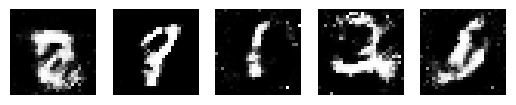

Epoch [9/20], Step [100/6000], d_loss: 1.0581, g_loss: 0.9722, D(x): 0.70, D(G(z)): 0.44
Epoch [9/20], Step [200/6000], d_loss: 1.0722, g_loss: 0.9682, D(x): 0.62, D(G(z)): 0.41
Epoch [9/20], Step [300/6000], d_loss: 1.2171, g_loss: 1.1929, D(x): 0.62, D(G(z)): 0.43
Epoch [9/20], Step [400/6000], d_loss: 1.2601, g_loss: 0.9031, D(x): 0.60, D(G(z)): 0.45
Epoch [9/20], Step [500/6000], d_loss: 1.1548, g_loss: 0.9630, D(x): 0.68, D(G(z)): 0.45
Epoch [9/20], Step [600/6000], d_loss: 1.1859, g_loss: 0.9549, D(x): 0.57, D(G(z)): 0.38
Epoch [9/20], Step [700/6000], d_loss: 1.1530, g_loss: 0.9495, D(x): 0.64, D(G(z)): 0.41
Epoch [9/20], Step [800/6000], d_loss: 1.2366, g_loss: 0.9482, D(x): 0.57, D(G(z)): 0.41
Epoch [9/20], Step [900/6000], d_loss: 1.3183, g_loss: 0.9465, D(x): 0.61, D(G(z)): 0.46
Epoch [9/20], Step [1000/6000], d_loss: 1.2491, g_loss: 0.9239, D(x): 0.56, D(G(z)): 0.43
Epoch [9/20], Step [1100/6000], d_loss: 1.1607, g_loss: 1.0492, D(x): 0.56, D(G(z)): 0.39
Epoch [9/20], Step 

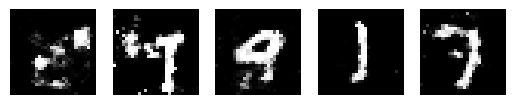

Epoch [11/20], Step [100/6000], d_loss: 1.3004, g_loss: 0.9932, D(x): 0.55, D(G(z)): 0.43
Epoch [11/20], Step [200/6000], d_loss: 1.2133, g_loss: 0.9285, D(x): 0.58, D(G(z)): 0.43
Epoch [11/20], Step [300/6000], d_loss: 1.1800, g_loss: 0.9096, D(x): 0.58, D(G(z)): 0.37
Epoch [11/20], Step [400/6000], d_loss: 1.2662, g_loss: 0.8519, D(x): 0.62, D(G(z)): 0.49
Epoch [11/20], Step [500/6000], d_loss: 1.2401, g_loss: 1.0162, D(x): 0.60, D(G(z)): 0.45
Epoch [11/20], Step [600/6000], d_loss: 1.2259, g_loss: 0.8330, D(x): 0.61, D(G(z)): 0.43
Epoch [11/20], Step [700/6000], d_loss: 1.1554, g_loss: 1.0079, D(x): 0.61, D(G(z)): 0.42
Epoch [11/20], Step [800/6000], d_loss: 1.3329, g_loss: 1.0279, D(x): 0.55, D(G(z)): 0.43
Epoch [11/20], Step [900/6000], d_loss: 1.1361, g_loss: 1.1418, D(x): 0.53, D(G(z)): 0.34
Epoch [11/20], Step [1000/6000], d_loss: 1.3183, g_loss: 0.8704, D(x): 0.55, D(G(z)): 0.44
Epoch [11/20], Step [1100/6000], d_loss: 1.1717, g_loss: 0.9431, D(x): 0.59, D(G(z)): 0.42
Epoch [1

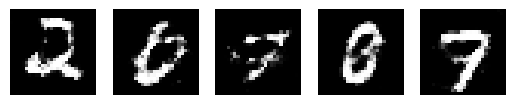

Epoch [13/20], Step [100/6000], d_loss: 1.2935, g_loss: 0.8614, D(x): 0.58, D(G(z)): 0.45
Epoch [13/20], Step [200/6000], d_loss: 1.2703, g_loss: 0.8760, D(x): 0.61, D(G(z)): 0.48
Epoch [13/20], Step [300/6000], d_loss: 1.0981, g_loss: 0.9511, D(x): 0.60, D(G(z)): 0.39
Epoch [13/20], Step [400/6000], d_loss: 1.3012, g_loss: 0.9275, D(x): 0.58, D(G(z)): 0.47
Epoch [13/20], Step [500/6000], d_loss: 1.0797, g_loss: 1.0540, D(x): 0.61, D(G(z)): 0.39
Epoch [13/20], Step [600/6000], d_loss: 1.1315, g_loss: 1.0712, D(x): 0.59, D(G(z)): 0.39
Epoch [13/20], Step [700/6000], d_loss: 1.1518, g_loss: 0.9995, D(x): 0.62, D(G(z)): 0.43
Epoch [13/20], Step [800/6000], d_loss: 1.1856, g_loss: 0.7696, D(x): 0.66, D(G(z)): 0.48
Epoch [13/20], Step [900/6000], d_loss: 1.1311, g_loss: 1.0656, D(x): 0.61, D(G(z)): 0.40
Epoch [13/20], Step [1000/6000], d_loss: 1.2758, g_loss: 0.8719, D(x): 0.62, D(G(z)): 0.51
Epoch [13/20], Step [1100/6000], d_loss: 1.2165, g_loss: 0.9160, D(x): 0.56, D(G(z)): 0.40
Epoch [1

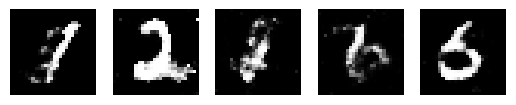

Epoch [15/20], Step [100/6000], d_loss: 1.3714, g_loss: 1.0221, D(x): 0.53, D(G(z)): 0.47
Epoch [15/20], Step [200/6000], d_loss: 1.1479, g_loss: 0.8002, D(x): 0.62, D(G(z)): 0.44
Epoch [15/20], Step [300/6000], d_loss: 1.1225, g_loss: 0.9038, D(x): 0.54, D(G(z)): 0.34
Epoch [15/20], Step [400/6000], d_loss: 1.1895, g_loss: 0.9414, D(x): 0.57, D(G(z)): 0.41
Epoch [15/20], Step [500/6000], d_loss: 1.1720, g_loss: 0.8849, D(x): 0.61, D(G(z)): 0.44
Epoch [15/20], Step [600/6000], d_loss: 1.2470, g_loss: 0.9980, D(x): 0.54, D(G(z)): 0.41
Epoch [15/20], Step [700/6000], d_loss: 1.4698, g_loss: 0.8128, D(x): 0.56, D(G(z)): 0.50
Epoch [15/20], Step [800/6000], d_loss: 1.1320, g_loss: 0.8515, D(x): 0.60, D(G(z)): 0.39
Epoch [15/20], Step [900/6000], d_loss: 1.4420, g_loss: 0.8632, D(x): 0.52, D(G(z)): 0.49
Epoch [15/20], Step [1000/6000], d_loss: 1.2119, g_loss: 1.0902, D(x): 0.57, D(G(z)): 0.42
Epoch [15/20], Step [1100/6000], d_loss: 1.2099, g_loss: 1.0283, D(x): 0.60, D(G(z)): 0.43
Epoch [1

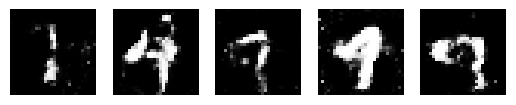

Epoch [17/20], Step [100/6000], d_loss: 1.3254, g_loss: 0.9108, D(x): 0.54, D(G(z)): 0.44
Epoch [17/20], Step [200/6000], d_loss: 1.3202, g_loss: 0.8866, D(x): 0.54, D(G(z)): 0.42
Epoch [17/20], Step [300/6000], d_loss: 1.2424, g_loss: 0.9038, D(x): 0.63, D(G(z)): 0.48
Epoch [17/20], Step [400/6000], d_loss: 1.3141, g_loss: 0.8602, D(x): 0.55, D(G(z)): 0.43
Epoch [17/20], Step [500/6000], d_loss: 1.2933, g_loss: 0.7564, D(x): 0.64, D(G(z)): 0.54
Epoch [17/20], Step [600/6000], d_loss: 1.3908, g_loss: 0.9928, D(x): 0.51, D(G(z)): 0.45
Epoch [17/20], Step [700/6000], d_loss: 1.2383, g_loss: 1.0978, D(x): 0.55, D(G(z)): 0.42
Epoch [17/20], Step [800/6000], d_loss: 1.2943, g_loss: 0.6978, D(x): 0.59, D(G(z)): 0.50
Epoch [17/20], Step [900/6000], d_loss: 1.0917, g_loss: 1.2821, D(x): 0.57, D(G(z)): 0.36
Epoch [17/20], Step [1000/6000], d_loss: 1.3181, g_loss: 0.8657, D(x): 0.59, D(G(z)): 0.49
Epoch [17/20], Step [1100/6000], d_loss: 1.1409, g_loss: 1.0507, D(x): 0.58, D(G(z)): 0.38
Epoch [1

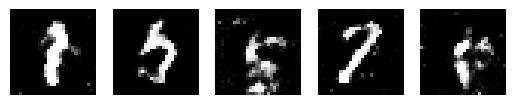

Epoch [19/20], Step [100/6000], d_loss: 1.1118, g_loss: 1.0087, D(x): 0.62, D(G(z)): 0.42
Epoch [19/20], Step [200/6000], d_loss: 1.2461, g_loss: 0.6872, D(x): 0.58, D(G(z)): 0.45
Epoch [19/20], Step [300/6000], d_loss: 1.2465, g_loss: 0.9264, D(x): 0.52, D(G(z)): 0.40
Epoch [19/20], Step [400/6000], d_loss: 1.2840, g_loss: 1.0316, D(x): 0.57, D(G(z)): 0.47
Epoch [19/20], Step [500/6000], d_loss: 1.2391, g_loss: 0.9704, D(x): 0.53, D(G(z)): 0.40
Epoch [19/20], Step [600/6000], d_loss: 1.1603, g_loss: 0.9766, D(x): 0.64, D(G(z)): 0.45
Epoch [19/20], Step [700/6000], d_loss: 1.2971, g_loss: 0.9211, D(x): 0.53, D(G(z)): 0.45
Epoch [19/20], Step [800/6000], d_loss: 1.2830, g_loss: 0.8315, D(x): 0.52, D(G(z)): 0.43
Epoch [19/20], Step [900/6000], d_loss: 1.6476, g_loss: 0.9159, D(x): 0.46, D(G(z)): 0.51
Epoch [19/20], Step [1000/6000], d_loss: 1.2937, g_loss: 0.8814, D(x): 0.51, D(G(z)): 0.42
Epoch [19/20], Step [1100/6000], d_loss: 1.1854, g_loss: 1.0010, D(x): 0.65, D(G(z)): 0.47
Epoch [1

In [13]:
batch_size = 32

# 打乱顺序并只使用 1/100 的数据预训练
subset_size = len(mnist_data) // 1
indices = list(range(len(mnist_data)))
subset_indices = indices[:subset_size]

# 划分训练集、验证集和测试集的索引
train_size = int(0.8 * len(subset_indices))
val_size = int(0.1 * len(subset_indices))
test_size = len(subset_indices) - train_size - val_size
train_indices = subset_indices[:train_size]
val_indices = subset_indices[train_size:train_size + val_size]
test_indices = subset_indices[train_size + val_size:]

# 创建不同的采样器
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

# 数据加载器
train_loader = DataLoader(dataset=mnist_data, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset=mnist_data, batch_size=batch_size, sampler=val_sampler)
test_loader = DataLoader(dataset=mnist_data, batch_size=batch_size, sampler=test_sampler)

# 定义损失函数、优化器、学习率
loss_fn = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

# 迭代次数与计时
num_epochs = 20
start = time.perf_counter()  # 开始时间

# 存储不同的指标
d_losses = []
g_losses = []
real_scores = []
fake_scores = []

# 开始训练
for epoch in range(num_epochs):
    # 训练过程
    G.train()
    D.train()
    for i, (images, _) in enumerate(train_loader):  # 当前 step
        batch_size = images.size(0)  # 变成一维向量
        images = images.reshape(batch_size, image_size).to(device)

        d_loss, real_score, fake_score = train_discriminator(images, batch_size)
        real_labels = torch.ones(batch_size, 1).to(device)  # 生成 real_labels
        g_loss = train_generator(batch_size, real_labels)

        # 存储不同指标
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        real_scores.append(real_score.mean().item())
        fake_scores.append(fake_score.mean().item())

        # 优化完成，下面进行一些反馈，展示学习进度
        if i % 100 == 0:
            print("Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}"
                 .format(epoch, num_epochs, i, len(train_loader), d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()))
        # 每隔一定的 epoch 展示生成的图像
        if (epoch + 1) % 2 == 0 and i == 0:
            display_images(G, 5)


# 训练结束，跳出循环，检验成果
end = time.perf_counter()  # 结束时间
total = end - start
minutes = total // 60
seconds = total - minutes * 60
print("利用 GPU 总用时：{:.2f} 分钟 {:.2f} 秒".format(minutes, seconds))

### 4.9 效果评估

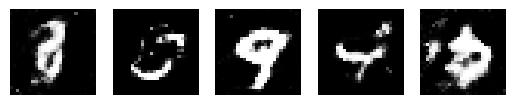

In [14]:
# 向 G 输入一个噪声，观察生成的图片
display_images(G, 5)  # 显示 5 张生成的图片

__可以看出效果有提升但训练效果一般__

<a id="2"></a>
## 五、DCGAN
### 5.1 生成器、判别器定义
生成器和判别器从全链接改成卷积

In [16]:
import os, time
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

# G(z)
class generator(nn.Module):
    # initializers
    def __init__(self):
        super(generator, self).__init__()
        self.fc1_1 = nn.Linear(100, 256)
        self.fc1_1_bn = nn.BatchNorm1d(256)
        self.fc1_2 = nn.Linear(10, 256)
        self.fc1_2_bn = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(512, 512)
        self.fc2_bn = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc3_bn = nn.BatchNorm1d(1024)
        self.fc4 = nn.Linear(1024, 784)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input, label):
        x = F.relu(self.fc1_1_bn(self.fc1_1(input)))
        y = F.relu(self.fc1_2_bn(self.fc1_2(label)))
        x = torch.cat([x, y], 1)
        x = F.relu(self.fc2_bn(self.fc2(x)))
        x = F.relu(self.fc3_bn(self.fc3(x)))
        x = F.tanh(self.fc4(x))

        return x

class discriminator(nn.Module):
    # initializers
    def __init__(self):
        super(discriminator, self).__init__()
        self.fc1_1 = nn.Linear(784, 1024)
        self.fc1_2 = nn.Linear(10, 1024)
        self.fc2 = nn.Linear(2048, 512)
        self.fc2_bn = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 256)
        self.fc3_bn = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input, label):
        x = F.leaky_relu(self.fc1_1(input), 0.2)
        y = F.leaky_relu(self.fc1_2(label), 0.2)
        x = torch.cat([x, y], 1)
        x = F.leaky_relu(self.fc2_bn(self.fc2(x)), 0.2)
        x = F.leaky_relu(self.fc3_bn(self.fc3(x)), 0.2)
        x = F.sigmoid(self.fc4(x))

        return x

### 5.2 定义权重初始化函数
对于输入的模块 m，如果是 nn.Linear 类型，将其权重初始化为均值为 mean 标准差为 std 的正态分布，将偏置置零。

In [17]:
def normal_init(m, mean, std):
    if isinstance(m, nn.Linear):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

### 5.3 One-Hot编码

In [19]:
# 制作输入数据
temp_z_ = torch.rand(10, 100)
fixed_z_ = temp_z_
fixed_y_ = torch.zeros(10, 1)
for i in range(9):
    fixed_z_ = torch.cat([fixed_z_, temp_z_], 0)
    temp = torch.ones(10,1) + i
    fixed_y_ = torch.cat([fixed_y_, temp], 0)

# One-Hot编码
with torch.no_grad():
    fixed_z_ = fixed_z_.cpu()
    fixed_y_label_ = torch.zeros(100, 10)
    fixed_y_label_.scatter_(1, fixed_y_.type(torch.LongTensor), 1)
    fixed_y_label_ = fixed_y_label_.cpu()

### 5.4 定义结果显示函数

In [20]:
# 定义显示图片的函数
def show_result(num_epoch, show = False, save = False, path = 'result.png'):

    G.eval()
    test_images = G(fixed_z_, fixed_y_label_)
    G.train()

    size_figure_grid = 10
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(10*10):
        i = k // 10
        j = k % 10
        ax[i, j].cla()
        ax[i, j].imshow(test_images[k].cpu().data.view(28, 28).numpy(), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

# 定义一个记录loss值的函数，便于绘制loss变化曲线
def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

### 5.5 参数
与GAN保持一致

In [26]:
# training parameters
batch_size = 128
lr = 0.0002
train_epoch = 20

# data_loader
# transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
])
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True)

# network
G = generator()
D = discriminator()
G.weight_init(mean=0, std=0.02)
D.weight_init(mean=0, std=0.02)
G.cpu()
D.cpu()

# Binary Cross Entropy loss
BCE_loss = nn.BCELoss()

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# results save folder
if not os.path.isdir('MNIST_cGAN_results'):
    os.mkdir('MNIST_cGAN_results')
if not os.path.isdir('MNIST_cGAN_results/Fixed_results'):
    os.mkdir('MNIST_cGAN_results/Fixed_results')

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []

### 5.6 模型训练

training start!
G_train_loss: tensor(0.7004, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.3967, grad_fn=<AddBackward0>)
G_train_loss: tensor(0.6975, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.3905, grad_fn=<AddBackward0>)
G_train_loss: tensor(0.6980, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.3851, grad_fn=<AddBackward0>)
G_train_loss: tensor(0.7000, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.3839, grad_fn=<AddBackward0>)
G_train_loss: tensor(0.6989, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.3821, grad_fn=<AddBackward0>)
G_train_loss: tensor(0.6996, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.3796, grad_fn=<AddBackward0>)
G_train_loss: tensor(0.7001, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.3771, grad_fn=<AddBackward0>)
G_train_loss: tensor(0.7043, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.3766, grad_fn=<AddBackward0>)
G_train_loss: te

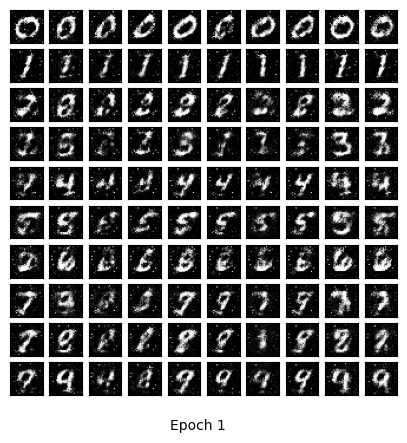

G_train_loss: tensor(1.2046, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.1150, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.0904, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.0110, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.0624, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.0712, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.0058, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.0645, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.1067, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.1486, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.0050, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.0820, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.1018, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.0599, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.0069, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.0181, grad_fn=<AddBackward0>)
G_train_loss: tensor(0.9824, gra

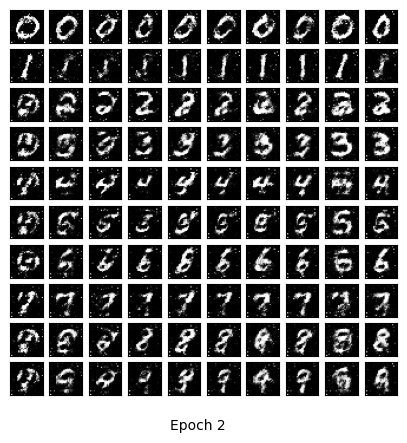

G_train_loss: tensor(1.3789, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.8968, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.5961, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.9103, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.3884, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.8088, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.2880, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.3461, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.2595, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.9455, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.2696, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.9988, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.3286, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.0558, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.4338, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.0407, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.4362, gra

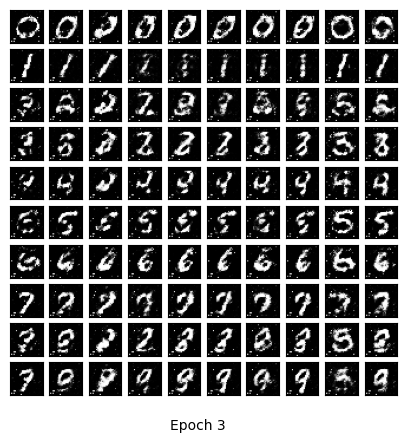

G_train_loss: tensor(1.4089, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.1452, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.2805, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.1261, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.3258, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.8316, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.5321, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.8481, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.5215, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.8397, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.2290, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.8464, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.4861, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.7977, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.1035, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.9633, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.3692, gra

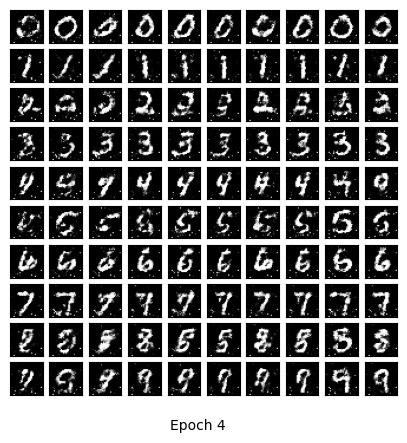

G_train_loss: tensor(1.4896, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.7804, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.9496, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.8252, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.1437, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.7801, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.8226, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.0110, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.9403, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.6821, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.5499, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.9068, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.6336, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.6598, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.5642, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.8632, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.4225, gra

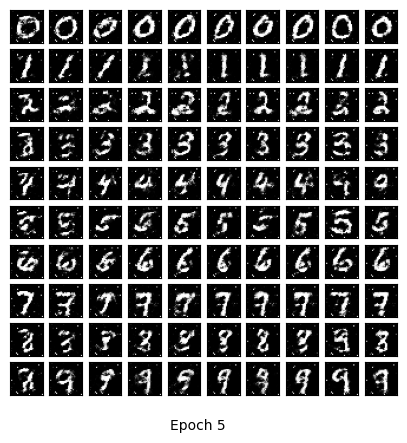

G_train_loss: tensor(1.9929, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.7026, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.7311, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.5580, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.0055, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.9845, grad_fn=<AddBackward0>)
G_train_loss: tensor(2.0083, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.8687, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.9908, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.8621, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.7554, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.9512, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.6709, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.6173, grad_fn=<AddBackward0>)
G_train_loss: tensor(2.0816, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.0999, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.4939, gra

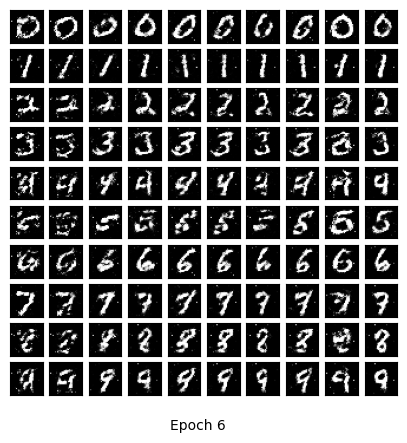

G_train_loss: tensor(1.6075, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.0306, grad_fn=<AddBackward0>)
G_train_loss: tensor(0.9172, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.0915, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.1694, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.9424, grad_fn=<AddBackward0>)
G_train_loss: tensor(2.0230, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.8481, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.7103, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.9467, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.5703, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.8834, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.0931, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.9651, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.3957, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.1770, grad_fn=<AddBackward0>)
G_train_loss: tensor(2.0752, gra

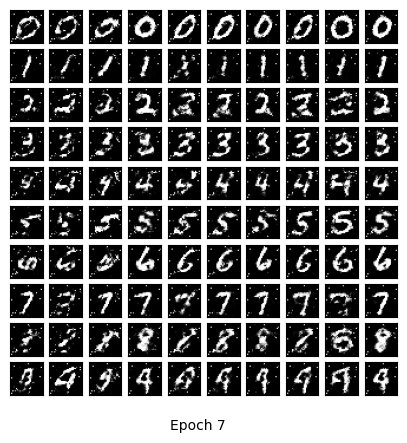

G_train_loss: tensor(1.4174, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.8213, grad_fn=<AddBackward0>)
G_train_loss: tensor(2.0170, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.6868, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.3394, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.9780, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.4015, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.8986, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.6583, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.0492, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.6124, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.8445, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.8124, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.7894, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.6666, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.4392, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.6858, gra

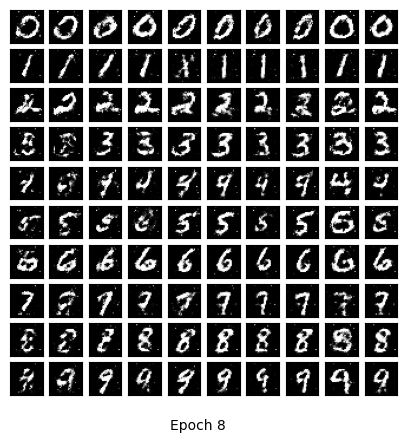

G_train_loss: tensor(1.8429, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.8179, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.3094, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.0413, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.1174, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.7858, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.5868, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.0182, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.2437, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.0783, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.6925, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.7264, grad_fn=<AddBackward0>)
tensor(1.5241, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.9179, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.3884, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.7619, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.2777, grad_fn=<BinaryCr

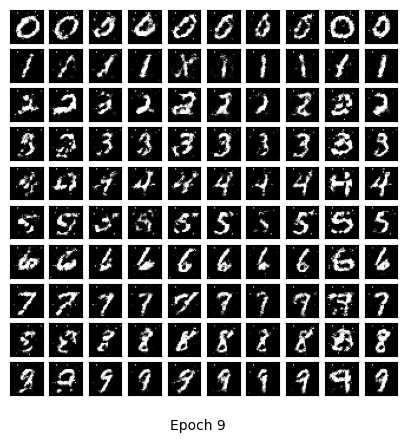

G_train_loss: tensor(1.7905, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.5666, grad_fn=<AddBackward0>)
G_train_loss: tensor(2.1855, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.5504, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.0608, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.7191, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.5885, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.8247, grad_fn=<AddBackward0>)
G_train_loss: tensor(2.3287, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.7487, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.6206, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.9913, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.4252, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.2510, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.9294, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.6118, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.3098, gra

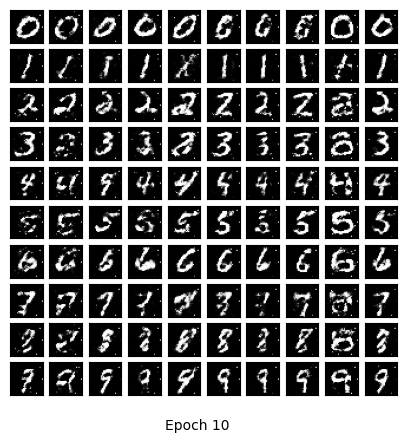

G_train_loss: tensor(1.2827, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.8771, grad_fn=<AddBackward0>)
G_train_loss: tensor(2.1004, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.7648, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.5309, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.7461, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.4209, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.9459, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.5348, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.0468, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.5009, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.7016, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.3363, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.9303, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.3157, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.9647, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.6926, gra

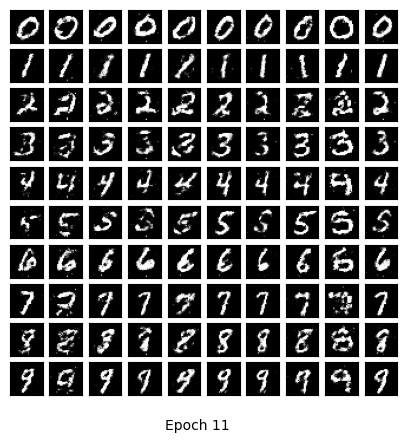

G_train_loss: tensor(1.2286, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.0924, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.4839, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.7177, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.5103, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.8905, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.5188, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.9537, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.4613, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.9146, grad_fn=<AddBackward0>)
G_train_loss: tensor(0.6980, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.3851, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.2907, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.8015, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.1825, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.9418, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.5810, gra

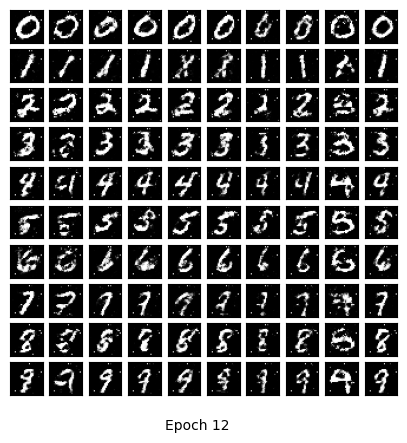

G_train_loss: tensor(1.0963, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.2425, grad_fn=<AddBackward0>)
G_train_loss: tensor(2.1742, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.8414, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.6294, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.5947, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.2100, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.9296, grad_fn=<AddBackward0>)
G_train_loss: tensor(0.6846, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.8560, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.8209, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.8433, grad_fn=<AddBackward0>)
G_train_loss: tensor(2.1144, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.9321, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.5523, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.7996, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.0347, gra

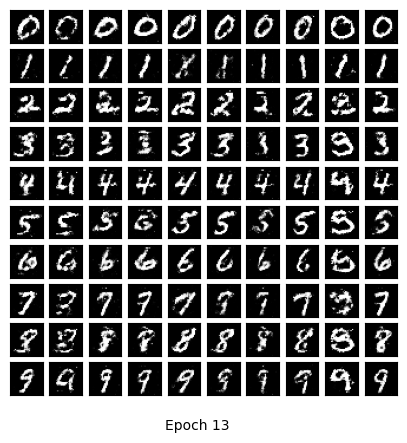

G_train_loss: tensor(1.2268, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.7423, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.2611, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.8749, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.7361, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.8576, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.1909, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.1146, grad_fn=<AddBackward0>)
G_train_loss: tensor(0.7655, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.2033, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.2348, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.9104, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.7662, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.9282, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.4527, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.1741, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.1343, gra

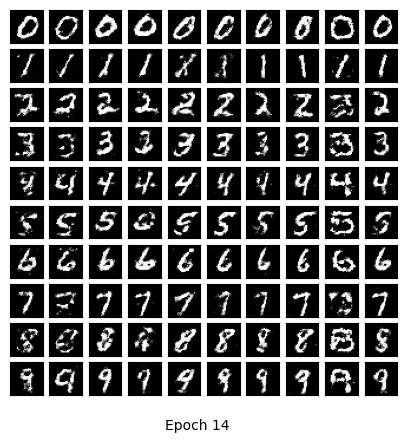

G_train_loss: tensor(1.4035, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.2540, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.3543, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.4555, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.4300, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.9010, grad_fn=<AddBackward0>)
G_train_loss: tensor(2.2174, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.0060, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.3224, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.3656, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.1379, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.7237, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.2958, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.4030, grad_fn=<AddBackward0>)
G_train_loss: tensor(0.8066, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.9804, grad_fn=<AddBackward0>)
G_train_loss: tensor(0.9443, gra

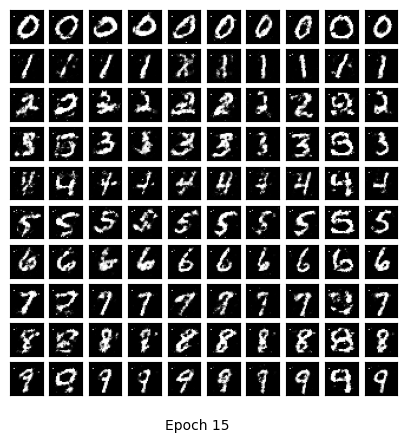

G_train_loss: tensor(1.2074, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.9703, grad_fn=<AddBackward0>)
G_train_loss: tensor(0.8309, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.4018, grad_fn=<AddBackward0>)
G_train_loss: tensor(0.8881, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.9586, grad_fn=<AddBackward0>)
G_train_loss: tensor(2.0832, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.2884, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.6586, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.8741, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.3530, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.7576, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.3283, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.8734, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.2098, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.1414, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.9421, gra

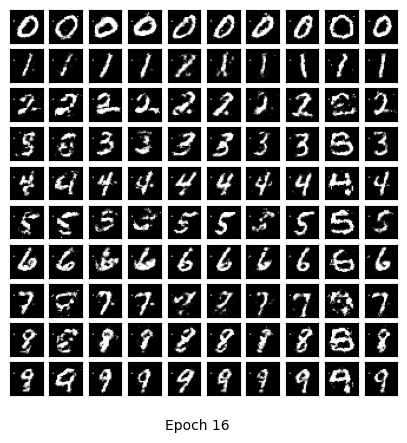

G_train_loss: tensor(2.5276, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.9887, grad_fn=<AddBackward0>)
G_train_loss: tensor(2.0016, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.9522, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.5240, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.9113, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.6276, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.9024, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.4609, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.8503, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.3463, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.7838, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.3605, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.8883, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.6508, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.8538, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.4758, gra

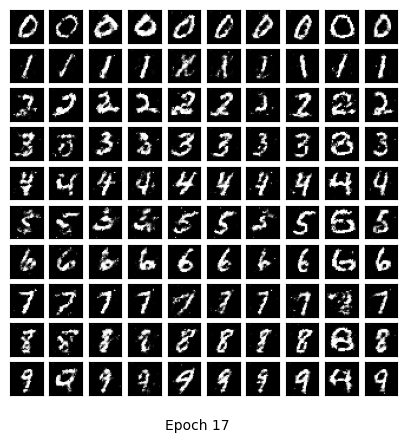

G_train_loss: tensor(1.8389, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.5692, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.5629, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.5598, grad_fn=<AddBackward0>)
G_train_loss: tensor(2.1587, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.5252, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.1311, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.5632, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.8862, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.5267, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.2399, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.7423, grad_fn=<AddBackward0>)
G_train_loss: tensor(2.0906, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.7086, grad_fn=<AddBackward0>)
G_train_loss: tensor(2.0021, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.0162, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.0510, gra

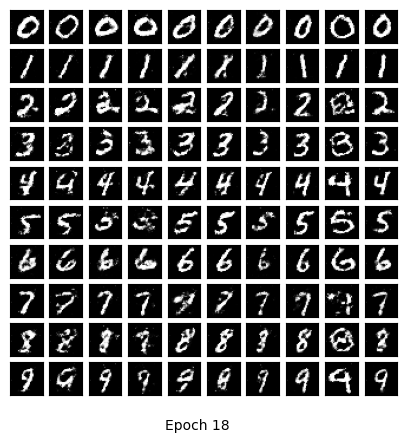

G_train_loss: tensor(1.8623, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.9391, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.9668, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.8249, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.8918, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.9472, grad_fn=<AddBackward0>)
G_train_loss: tensor(0.9463, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.7165, grad_fn=<AddBackward0>)
G_train_loss: tensor(0.8799, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(1.0075, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.5248, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.7007, grad_fn=<AddBackward0>)
G_train_loss: tensor(2.0421, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.9336, grad_fn=<AddBackward0>)
G_train_loss: tensor(2.4837, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.5733, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.7607, gra

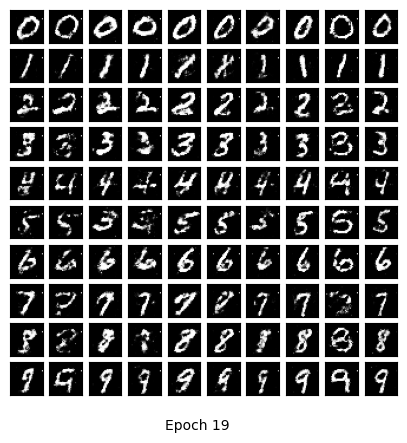

G_train_loss: tensor(1.3743, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.7027, grad_fn=<AddBackward0>)
G_train_loss: tensor(2.8386, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.5593, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.7322, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.7756, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.9443, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.6166, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.5218, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.5674, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.3230, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.6437, grad_fn=<AddBackward0>)
G_train_loss: tensor(2.4461, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.9634, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.6493, grad_fn=<BinaryCrossEntropyBackward0>) D_train_loss: tensor(0.6145, grad_fn=<AddBackward0>)
G_train_loss: tensor(1.9177, gra

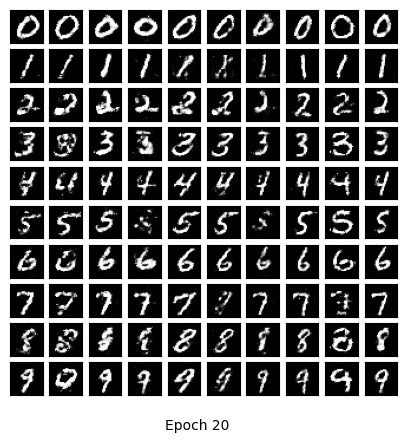

Avg one epoch ptime: 15.32, total 20 epochs ptime: 329.36
Training finish!... save training results


In [27]:
print('training start!')
start_time = time.time()
for epoch in range(train_epoch):
    D_losses = []
    G_losses = []

    # learning rate decay
    if (epoch+1) == 30:
        G_optimizer.param_groups[0]['lr'] /= 10
        D_optimizer.param_groups[0]['lr'] /= 10
        print("learning rate change!")

    if (epoch+1) == 40:
        G_optimizer.param_groups[0]['lr'] /= 10
        D_optimizer.param_groups[0]['lr'] /= 10
        print("learning rate change!")

    epoch_start_time = time.time()
    for x_, y_ in train_loader:
        # train discriminator D
        D.zero_grad()

        mini_batch = x_.size()[0]

        y_real_ = torch.ones(mini_batch)
        y_fake_ = torch.zeros(mini_batch)
        y_label_ = torch.zeros(mini_batch, 10)
        y_label_.scatter_(1, y_.view(mini_batch, 1), 1)

        x_ = x_.view(-1, 28 * 28)
        x_, y_label_, y_real_, y_fake_ = Variable(x_.cpu()), Variable(y_label_.cpu()), Variable(y_real_.cpu()), Variable(y_fake_.cpu())
        D_result = D(x_, y_label_).squeeze()
        D_real_loss = BCE_loss(D_result, y_real_)

        z_ = torch.rand((mini_batch, 100))
        y_ = (torch.rand(mini_batch, 1) * 10).type(torch.LongTensor)
        y_label_ = torch.zeros(mini_batch, 10)
        y_label_.scatter_(1, y_.view(mini_batch, 1), 1)

        z_, y_label_ = Variable(z_.cpu()), Variable(y_label_.cpu())
        G_result = G(z_, y_label_)

        D_result = D(G_result, y_label_).squeeze()
        D_fake_loss = BCE_loss(D_result, y_fake_)
        D_fake_score = D_result.data.mean()

        D_train_loss = D_real_loss + D_fake_loss

        D_train_loss.backward()
        D_optimizer.step()

        D_losses.append(D_train_loss.data)

        # train generator G
        G.zero_grad()

        z_ = torch.rand((mini_batch, 100))
        y_ = (torch.rand(mini_batch, 1) * 10).type(torch.LongTensor)
        y_label_ = torch.zeros(mini_batch, 10)
        y_label_.scatter_(1, y_.view(mini_batch, 1), 1)

        z_, y_label_ = Variable(z_.cpu()), Variable(y_label_.cpu())

        G_result = G(z_, y_label_)
        D_result = D(G_result, y_label_).squeeze()
        G_train_loss = BCE_loss(D_result, y_real_)
        G_train_loss.backward()
        G_optimizer.step()

        G_losses.append(G_train_loss.data)
        print('G_train_loss:', G_train_loss, 'D_train_loss:', D_train_loss)

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time

    print('[%d/%d] - ptime: %.2f, loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), train_epoch, per_epoch_ptime, torch.mean(torch.FloatTensor(D_losses)),
                                                              torch.mean(torch.FloatTensor(G_losses))))
    fixed_p = 'MNIST_cGAN_results/Fixed_results/MNIST_cGAN_' + str(epoch + 1) + '.png'
    show_result((epoch+1), show=True, save=True, path=fixed_p)
    train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))
    train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

end_time = time.time()
total_ptime = end_time - start_time
train_hist['total_ptime'].append(total_ptime)

print("Avg one epoch ptime: %.2f, total %d epochs ptime: %.2f" % (torch.mean(torch.FloatTensor(train_hist['per_epoch_ptimes'])), train_epoch, total_ptime))
print("Training finish!... save training results")

### 5.7 模型评价

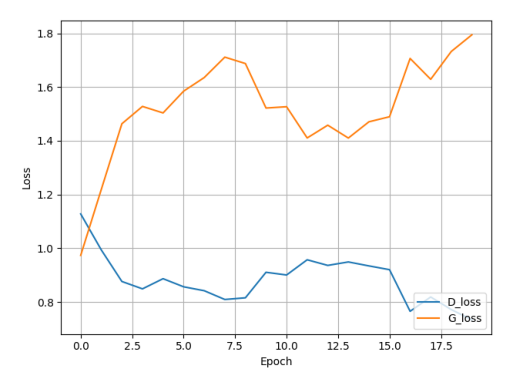

In [28]:
torch.save(G.state_dict(), "MNIST_cGAN_results/generator_param.pkl")
torch.save(D.state_dict(), "MNIST_cGAN_results/discriminator_param.pkl")
with open('MNIST_cGAN_results/train_hist.pkl', 'wb') as f:
    pickle.dump(train_hist, f)

show_train_hist(train_hist, save=True, path='MNIST_cGAN_results/MNIST_cGAN_train_hist.png')

import matplotlib.pyplot as plt
train_hist_img_path = 'MNIST_cGAN_results/MNIST_cGAN_train_hist.png'
train_hist_img = plt.imread(train_hist_img_path)
plt.imshow(train_hist_img)
plt.axis('off')
plt.show()

### 5.8 训练过程可视化

In [29]:
import imageio.v2 as imageio

# 制作 gif 动画
images = []
for e in range(train_epoch):
    img_name = 'MNIST_cGAN_results/Fixed_results/MNIST_cGAN_' + str(e + 1) + '.png'
    images.append(imageio.imread(img_name))
imageio.mimsave('MNIST_cGAN_results/generation_animation.gif', images, fps=5)

<img src="MNIST_cGAN_results/generation_animation.gif" />

__无论对比loss还是图像可以看出DCGAN的效果好了很多__

<a id="3"></a>
## 六、Flow-based Model（RealNVP）
### 6.1 函数定义
定义准确率曲线、最大最小归一化、正态分布采样、可视化函数

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import scipy as sp
import scipy.linalg

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torchvision import transforms
from torchvision.utils import save_image
import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定义准确率曲线
def plot_acc_loss(train_loss, test_loss):
  fig, axes = plt.subplots(1, 1, figsize=(4, 4), constrained_layout=True)
  # plt.subplots_adjust(left=0.1, bottom=0.1, right=0.15, top=0.15, wspace=0.2, hspace=0.5)
  plt.suptitle("Loss, Kl, reconstrucion loss and negetive elbo plot for train and test data", size=12)
  axes.plot(list(range(1, len(train_loss)+1)), train_loss, 'b', label='train errors')
  axes.plot(list(range(1, len(test_loss)+1)), test_loss, 'r',label='test errors')
  axes.set_ylabel('Loss Average', size=10, labelpad=11)
  axes.set_xlabel('Epoch', size=10, labelpad=5)
  axes.legend(loc='best', fontsize=8)
  axes.grid()

  plt.show()
  

# 定义最大最小归一化
def min_max_normalize(x):
    return (x-x.min())/(x.max()-x.min())

# 正态分布采样
def get_normal_sample(model):
  z = torch.distributions.normal.Normal(0.0, 1.0).sample([16, 28 * 28])
  with torch.no_grad():
      x, _ = model.backward(z.to(device))
  x = x.squeeze().cpu().numpy()
  return x

# 可视化
def plot_digits(x):
  fig, axes = plt.subplots(4, 4,figsize=(12,12))
  idx = 0
  for i in range(4):
    for j in range(4):
      data = min_max_normalize(x[idx])
      pixels = data.reshape((28, 28))
      axes[i][j].imshow(pixels, cmap='gray')
      idx+=1

### 6.2 数据导入
还是手写体数据

In [31]:
# 数据导入
batch_size = 256
train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('./data/',
                                                          download=True,
                                                          train=True,
                                                          transform=transforms.Compose([
                                                              transforms.Resize((28, 28)),
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                                          ])),
                                           batch_size=batch_size,
                                           shuffle=True)

# download and transform test dataset
test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('./data/',
                                                          download=True,
                                                          train=False,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                                          ])),
                                           batch_size=batch_size,
                                           shuffle=True)


### 6.3 定义模型

In [32]:
# 定义模型
class Scale(nn.Module):
    """
    Simple fully connected neural network.
    """
    def __init__(self, in_dim, out_dim, hidden_dim):
        super().__init__()

        self.scale = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.scale(x)


class Translation(nn.Module):
    """
    Simple fully connected neural network.
    """
    def __init__(self, in_dim, out_dim, hidden_dim):
        super().__init__()

        self.translation = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        return self.translation(x)
    
# 耦合
class Coupling(nn.Module):
    def __init__(self, dim, hidden_dim = 8):
        super(Coupling, self).__init__()

        self.s = Scale(dim // 2, dim // 2, hidden_dim)
        self.t = Translation(dim // 2, dim // 2, hidden_dim)

        self.dim = dim

    def forward(self, x):
        x_a, x_b = x[:,:self.dim // 2], x[:,self.dim // 2:]

        t1_transformed = self.t(x_a)
        s1_transformed = self.s(x_a)

        yb = (torch.exp(s1_transformed) * x_b) + t1_transformed
        ya = x_a

        z = torch.cat([ya, yb], dim=1)

        log_det_jacobian = torch.sum(s1_transformed, dim=1)

        return z, log_det_jacobian

    def backward(self, z):
        z_a, z_b = z[:,:self.dim // 2], z[:,self.dim // 2:]

        t1_transformed = self.t(z_a)
        s1_transformed = self.s(z_b)

        z_b = (z_b - t1_transformed) * torch.exp(-s1_transformed)

        z = torch.cat([z_a, z_b], dim=1)

        inv_log_det_jacobian = torch.sum(-s1_transformed, dim=1)

        return z, inv_log_det_jacobian
    
# 定义RealNVP
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal

class RealNVP(nn.Module):

    def __init__(self, dim, layers):
        super().__init__()
        self.prior = MultivariateNormal(torch.zeros(dim, device=device), torch.eye(dim, device=device))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        bsz, _ = x.shape
        log_det = torch.zeros(bsz, device=device)
        for layer in self.layers:
            x, log_det_jacobian = layer.forward(x)
            x = x.flip(1)
            log_det += log_det_jacobian
        prior_logprob = self.prior.log_prob(x)
        return x, prior_logprob, log_det

    def backward(self, z):
        shp, _ = z.shape
        log_det = torch.zeros(shp, device=device)
        for layer in self.layers[::-1]:
            z, inv_log_det = layer.backward(z)
            log_det += inv_log_det
        return z, log_det

### 6.4 定义训练与测试函数

In [33]:
# 测试集
def test(test_loader, epoch, device):
    val_loss = 0
    model.eval()
    loop_test = tqdm(enumerate(test_loader, 1), total=len(test_loader), desc="Test", position=0, leave=True)
    for batch_index, training_sample in loop_test:
        img = training_sample[0].to(device)
        batch_len = img.size(0)
        img_vector = img.reshape(batch_len, -1)
        z, prior_logprob, log_det = model(img_vector)

        logprob = prior_logprob + abs(log_det)
        loss = -torch.mean(logprob)

        val_loss += loss

        loop_test.set_description(f"Test - iteration : {epoch}")
        loop_test.set_postfix(
          loss_batch="{:.4f}".format(val_loss.detach().item() / batch_index),
          refresh=True,
    )

    val_loss /= len(loop_test)
    return val_loss

# 训练集
def train(model, train_loader, test_loader, epochs, batch_size, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    validation_losses = []
    model.to(device)
    for epoch in tqdm(range(1, epochs + 1)):
        model.train()
        epoch_loss = 0
        loop_train = tqdm(enumerate(train_loader, 1), total=len(train_loader), desc="train", position=0, leave=True)
        for batch_index, training_sample in loop_train:

            optimizer.zero_grad()

            img = training_sample[0].to(device)
            batch_len = img.size(0)
            img_vector = img.reshape(batch_len, -1)
            z, prior_logprob, log_det = model(img_vector)

            logprob = prior_logprob + abs(log_det)
            loss = -torch.mean(logprob)

            loss.backward()
            optimizer.step()

            epoch_loss += loss

            loop_train.set_description(f"Train - iteration : {epoch}")
            loop_train.set_postfix(
              loss_batch="{:.4f}".format(epoch_loss.detach().item() / batch_index),
              refresh=True,
        )

        epoch_loss /= len(train_loader)
        train_losses.append(np.copy(epoch_loss.detach().cpu().numpy()))

        val_loss = test(test_loader, epoch, device)
        validation_losses.append(np.copy(val_loss.detach().cpu().numpy()))


    return model, train_losses, validation_losses

### 6.5 小样本预训练调参

Train - iteration : 1: 100%|█| 3/3 [00:00<00:00, 21.98it/s, loss_batch=1215.7301
Test - iteration : 1: 100%|█| 1/1 [00:00<00:00, 112.11it/s, loss_batch=1172.2975
Train - iteration : 2: 100%|█| 3/3 [00:00<00:00, 57.85it/s, loss_batch=1179.5008
Test - iteration : 2: 100%|█| 1/1 [00:00<00:00, 130.07it/s, loss_batch=1146.3550
Train - iteration : 3: 100%|█| 3/3 [00:00<00:00, 58.12it/s, loss_batch=1156.5627
Test - iteration : 3: 100%|█| 1/1 [00:00<00:00, 117.45it/s, loss_batch=1123.8612
Train - iteration : 4: 100%|█| 3/3 [00:00<00:00, 50.75it/s, loss_batch=1128.3592
Test - iteration : 4: 100%|█| 1/1 [00:00<00:00, 102.16it/s, loss_batch=1099.2031
Train - iteration : 5: 100%|█| 3/3 [00:00<00:00, 46.23it/s, loss_batch=1099.3428
Test - iteration : 5: 100%|█| 1/1 [00:00<00:00, 103.86it/s, loss_batch=1071.4301
Train - iteration : 6: 100%|█| 3/3 [00:00<00:00, 54.04it/s, loss_batch=1072.6323
Test - iteration : 6: 100%|█| 1/1 [00:00<00:00, 129.51it/s, loss_batch=1039.8452
Train - iteration : 7: 100%|

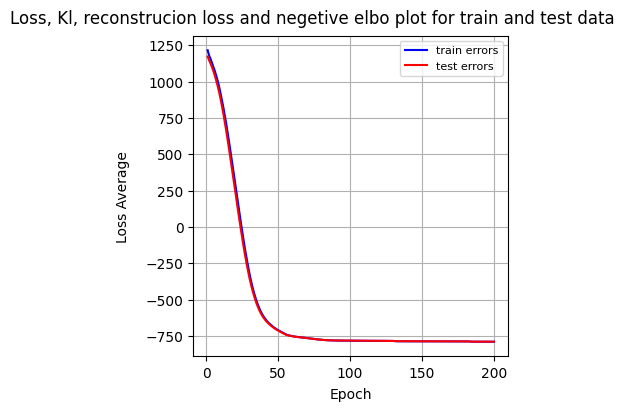

In [34]:
# 预训练样本，取1/100
total_samples = len(train_loader.dataset)
subset_size = total_samples // 100
subset_dataset = torch.utils.data.Subset(train_loader.dataset, range(subset_size))
subset_train_loader = torch.utils.data.DataLoader(subset_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

total_samples = len(test_loader.dataset)
subset_size = total_samples // 100
subset_dataset = torch.utils.data.Subset(test_loader.dataset, range(subset_size))
subset_test_loader = torch.utils.data.DataLoader(subset_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

# 模型训练
num_layers = 4
dim = 1 * 28 * 28
layer = Coupling
device = 'cpu'
epochs = 200
batch_size = 256

layers = [layer(dim=dim) for _ in range(num_layers)]

model = RealNVP(dim=dim, layers=layers)

model, train_loss, test_loss = train(model, subset_train_loader, subset_test_loader, epochs, batch_size, device)

plot_acc_loss(train_loss, test_loss)

### 6.6 全样本模型训练

Train - iteration : 1: 100%|█| 235/235 [00:04<00:00, 52.33it/s, loss_batch=602.3
Test - iteration : 1: 100%|█| 40/40 [00:00<00:00, 67.75it/s, loss_batch=234.4080
Train - iteration : 2: 100%|█| 235/235 [00:04<00:00, 55.88it/s, loss_batch=141.0
Test - iteration : 2: 100%|█| 40/40 [00:00<00:00, 52.32it/s, loss_batch=58.8594]
Train - iteration : 3: 100%|█| 235/235 [00:04<00:00, 56.80it/s, loss_batch=27.34
Test - iteration : 3: 100%|█| 40/40 [00:00<00:00, 68.26it/s, loss_batch=-2.2500]
Train - iteration : 4: 100%|█| 235/235 [00:04<00:00, 54.25it/s, loss_batch=-15.6
Test - iteration : 4: 100%|█| 40/40 [00:00<00:00, 63.26it/s, loss_batch=-30.2342
Train - iteration : 5: 100%|█| 235/235 [00:04<00:00, 54.78it/s, loss_batch=-39.2
Test - iteration : 5: 100%|█| 40/40 [00:00<00:00, 69.64it/s, loss_batch=-50.2581
Train - iteration : 6: 100%|█| 235/235 [00:04<00:00, 56.64it/s, loss_batch=-55.9
Test - iteration : 6: 100%|█| 40/40 [00:00<00:00, 69.01it/s, loss_batch=-63.7385
Train - iteration : 7: 100%|

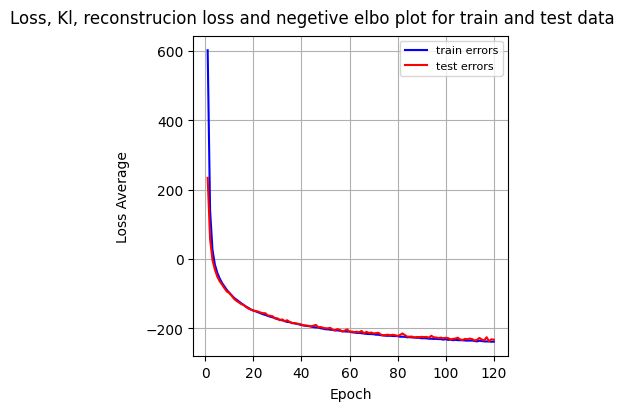

In [35]:
# 模型训练
num_layers = 4
dim = 1 * 28 * 28
layer = Coupling
device = 'cpu'
epochs = 120
batch_size = 256

layers = [layer(dim=dim) for _ in range(num_layers)]

model = RealNVP(dim=dim, layers=layers)

model, train_loss, test_loss = train(model, train_loader, test_loader, epochs, batch_size, device)

plot_acc_loss(train_loss, test_loss)

<a id="4"></a>
## 七、Diffusion Model
### 7.1 数据导入
还是手写体数据MNIST

In [1]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
from typing import Optional
from typing import Union
from typing import Tuple
from typing import List
import torch.nn as nn
import numpy as np
import torch
import math
import os
from tqdm import tqdm

## Diffusion Model（扩散模型）
# 数据导入
train_dir= '/Users/ouyangruizhi/Desktop/python/统计学习导论/生成模型/latent_diffusion_model_mnist-main/mnist/train/mnist_train.csv'
test_dir= '/Users/ouyangruizhi/Desktop/python/统计学习导论/生成模型/latent_diffusion_model_mnist-main/mnist/test/mnist_test.csv'

# 读取数据
def read_mnist(file_name):
    mnist= []
    with open(file_name, encoding= 'utf-8') as f:
        mnist= f.readlines()
    rows= len(mnist)
    mnist= np.array([int(item) for sting in mnist for item in sting.split(',')]).reshape(rows, -1)
    return torch.from_numpy(mnist[:, 1:]).float()/ 255.0, torch.from_numpy(mnist[:, 0])

# 
seed, batch_size= 1, 512
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
pics, labels= read_mnist(train_dir)
random_num= torch.rand(len(pics))
train_flag, valid_flag, test_flag= random_num< torch.tensor(0.8), (random_num>= torch.tensor(0.8))* (random_num< torch.tensor(0.9)), random_num>= torch.tensor(0.9)
train_pics, valid_pics, test_pics= pics[train_flag], pics[valid_flag], pics[test_flag]
train_labels, valid_labels, test_labels= labels[train_flag], labels[valid_flag], labels[test_flag]
train_set, valid_set, test_set= torch.utils.data.TensorDataset(train_pics, train_labels), torch.utils.data.TensorDataset(valid_pics, valid_labels), torch.utils.data.TensorDataset(test_pics, test_labels)
train_loader, valid_loader, test_loader= torch.utils.data.DataLoader(train_set, batch_size= batch_size, shuffle= True), torch.utils.data.DataLoader(valid_set, batch_size= batch_size, shuffle= True), torch.utils.data.DataLoader(test_set, batch_size= batch_size, shuffle= True)


### 7.2 定义模型和辅助函数

In [2]:
# 
class Tools:
    def gather(self, consts: torch.Tensor, t: torch.Tensor):
        c= consts.gather(-1, t)
        return c.reshape(-1, 1, 1, 1)

# 定义模型
class DenoiseDiffusion():
    def __init__(self, eps_model: nn.Module, n_steps: int, device: torch.device):
        super().__init__()
        self.eps_model= eps_model
        self.beta= torch.linspace(0.0001, 0.02, n_steps).to(device)
        self.alpha= 1.0- self.beta
        # compute cumulative product
        self.alpha_bar= torch.cumprod(self.alpha, dim= 0)
        self.n_steps= n_steps
        self.sigma= self.beta
        self.tools= Tools()

    # forward- diffusion
    def q_xt_x0(self, x0: torch.tensor, t:torch.Tensor):
        # compute mean and var of xt according to x0
        # xt= sqrt(at)*x0+ sqrt(1-at)*eps
        maen= self.tools.gather(self.alpha_bar, t)** 0.5* x0
        # (batch_size, 1, 1, 1)
        var= 1- self.tools.gather(self.alpha_bar, t)
        return maen, var

    # forward- diffusion
    def q_sample(self, x0: torch.Tensor, t: torch.Tensor, eps: Optional[torch.Tensor]= None):
        # compute xt according mean and var of xt
        if eps is None:
            eps= torch.randn_like(x0)
        maen, var= self.q_xt_x0(x0, t)
        return maen+ (var** 0.5)* eps
    
    # sampling
    def p_sample(self, xt: torch.tensor, t: torch.Tensor):
        # compute xt-1 according xt
        eps_hat= self.eps_model(xt, t)
        alpha_bar= self.tools.gather(self.alpha_bar, t)
        alpha= self.tools.gather(self.alpha, t)
        eps_coef= (1- alpha)/ (1- alpha_bar)** 0.5
        maen= 1/ (alpha** 0.5)* (xt- eps_coef* eps_hat)
        var= self.tools.gather(self.sigma, t)
        eps= torch.randn(xt.shape, device= xt.device)
        return maen+ (var** 0.5)* eps
    
    # loss
    # x0, (batch_size, C, H, W);
    def loss(self, x0: torch.tensor, noise: Optional[torch.Tensor]= None):
        # distance between loss
        batch_size= x0.shape[0]
        # (batch_size, )
        t= torch.randint(0, self.n_steps, (batch_size, ), device= x0.device, dtype= torch.long)
        if noise is None:noise= torch.randn_like(x0)
        xt= self.q_sample(x0, t, eps= noise)
        eps_hat= self.eps_model(xt, t)
        return F.mse_loss(noise, eps_hat)

class Swish(nn.Module):
    def forward(self, x):
        return x* torch.sigmoid(x)

class ResidualBolck(nn.Module):
    # n_groups, hyper-parameter of group norm
    # group norm, group normalize; first, split channels into different groups; then, normalize feature in every group, as batch_normalization, it has some hyper-parameters.
    # feat_map  
    # cv1(feat_map)+ cv2(time_emb) -> feat_map' + cv(feat_map) -> output
    def __init__(self, in_channels: int, out_channels: int, time_channels: int, n_groups: int= 16, dropout: float= 0.1):
        super().__init__()
        # in_channels// n_groups
        self.norm1= nn.GroupNorm(n_groups, in_channels)
        self.act1= Swish()
        self.conv1= nn.Conv2d(in_channels, out_channels, kernel_size= (3, 3), padding= (1, 1))
        self.norm2= nn.GroupNorm(n_groups, out_channels)
        self.act2= Swish()
        self.conv2= nn.Conv2d(out_channels, out_channels, kernel_size= (3, 3), padding= (1, 1))
        if in_channels!= out_channels:
            self.shortcut= nn.Conv2d(in_channels, out_channels, kernel_size= (1, 1))
        else:
            self.shortcut= nn.Identity()
        self.time_emb= nn.Linear(time_channels, out_channels)
        self.time_act= Swish()
        self.dropout= nn.Dropout(dropout)
    def forward(self, x: torch.Tensor, t:torch.Tensor):
        # norm>> act>> conv
        h= self.conv1(self.act1(self.norm1(x)))
        # time embedding, (batch_size, out_channels, 1, 1)
        # time embedding的不同特征与不同通道的特征图进行相加以实现空间与时间的融合
        h+= self.time_emb(self.time_act(t))[:, :, None, None]
        h= self.conv2(self.dropout(self.act2(self.norm2(h))))
        return h+ self.shortcut(x)

class AttentionBlock(nn.Module):
    def __init__(self, n_channels: int, n_heads: int= 1, k_dims: int= None, n_groups: int= 16):
        super().__init__()
        if k_dims is None:
            k_dims= n_channels
        self.norm= nn.GroupNorm(n_groups, n_channels)
        # as n_channels= 64, 64>> 8* 128* 3
        self.projection= nn.Linear(n_channels, n_heads* k_dims* 3)
        self.output= nn.Linear(n_heads* k_dims, n_channels)
        self.scale= k_dims** -0.5
        self.n_heads= n_heads
        self.k_dims= k_dims
    def forward(self, x: torch.Tensor, t: Optional[torch.Tensor]= None):
        _= t
        batch_size, n_channels, height, weight= x.shape
        # pull x straight, (batch_size, n_channels, H* W)>> (batch_size, H* W, n_channels)
        x= x.view(batch_size, n_channels, -1).permute(0, 2, 1)
        # (batch_size, H* W, channels)>> (batch_size, H* W, head, 3* k_head_dim)
        qkv= self.projection(x).view(batch_size, -1, self.n_heads, 3* self.k_dims)
        # q, (batch_size, H* W, head, k_head_dim); k, (batch_size, H* W, head, k_head_dim); v, (,,).
        q, k, v= torch.chunk(qkv, 3, dim= -1)
        # (batch_size, H* W, head, dim), (batch_size, H* W, head, dim) -> (batch_size, H* W, H* W, head)
        # This writing style is really good!
        attn= torch.einsum('bihd,bjhd->bijh', q, k)* self.scale
        attn= attn.softmax(dim= 2)
        # (batch_size, H* W, H* W, head), (batch_size, H* W, head, dim)
        res= torch.einsum('bijh,bjhd->bihd', attn, v)
        # (batch_size, H* W, head* dim)
        res= res.view(batch_size, -1, self.n_heads* self.k_dims)
        # (batch_size, H* W, C)
        res= self.output(res)
        res+= x
        res= res.permute(0, 2, 1).view(batch_size, n_channels, height, weight)
        return res

class DownBlock(nn.Module):
    # Encoder
    # DownBlock= ResidualBlock+ AttentionBlock
    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        self.res= ResidualBolck(in_channels, out_channels, time_channels)
        if has_attn:
            self.attn= AttentionBlock(out_channels)
        else:
            self.attn= nn.Identity()
    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x= self.res(x, t)
        x= self.attn(x)
        return x

class TimeEmbedding(nn.Module):
    def __init__(self, n_channels:int):
        super().__init__()
        self.n_channels= n_channels
        # n_channels// 8 and concate
        self.lin1= nn.Linear(self.n_channels// 4, self.n_channels)
        self.act= Swish()
        self.lin2= nn.Linear(self.n_channels, self.n_channels)
    def forward(self, t: torch.Tensor):
        half_dim= self.n_channels// 8
        emb= math.log(10000)/ (half_dim- 1)
        emb= torch.exp(torch.arange(half_dim, device= t.device)* -emb)
        emb= t[:, None]* emb[None, :]
        emb= torch.cat((emb.sin(), emb.cos()), dim= 1)
        # transform
        emb= self.act(self.lin1(emb))
        emb= self.lin2(emb)
        return emb        

class Upsample(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        # 反卷积，
        self.conv= nn.ConvTranspose2d(n_channels, n_channels, (4, 4), (2, 2), (1, 1))
    def forward(self, x: torch.Tensor, t: torch.Tensor):
        _= t
        return self.conv(x)

class Downsample(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.conv= nn.Conv2d(n_channels, n_channels, (3, 3), (2, 2), (1, 1))
    def forward(self, x:torch.tensor, t:torch.tensor):
        _= t
        return self.conv(x)

class MiddleBlock(nn.Module):
    def __init__(self, n_channels:int, time_channels:int):
        super().__init__()
        self.res1= ResidualBolck(n_channels, n_channels, time_channels)
        self.attn= AttentionBlock(n_channels)
        self.res2= ResidualBolck(n_channels, n_channels, time_channels)
    def forward(self, x:torch.tensor, t:torch.tensor):
        x= self.res1(x, t)
        x= self.attn(x)
        x= self.res2(x, t)
        return x

class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        # we concatenate the output of the same resolution
        self.res= ResidualBolck(in_channels+ out_channels, out_channels, time_channels)
        if has_attn:
            self.attn= AttentionBlock(out_channels)
        else:
            self.attn= nn.Identity()
    def forward(self, x:torch.Tensor, t:torch.Tensor):
        x= self.res(x, t)
        x= self.attn(x)
        return x

class UNet(nn.Module):
    def __init__(self, image_channels: int= 1, n_channels: int= 16, ch_mults: Union[tuple[int, ...], List[int]]= [1, 2, 2, 2], is_attn: Union[Tuple[bool, ...], List[int]]= (False, False, False, False), n_blocks: int= 1):
        super().__init__()
        # 
        n_resolutions= len(ch_mults)
        self.image_proj= nn.Conv2d(image_channels, n_channels, kernel_size= (3, 3), padding= (1, 1))
        self.time_emb= TimeEmbedding(n_channels* 4)
        # ---- Encoder ----
        down= []
        out_channels= in_channels= n_channels
        # for each layers
        for i in range(n_resolutions):
            # 16* (1, 2, 2, 2)
            out_channels= in_channels* ch_mults[i]
            for _ in range(n_blocks):
                # residual+ attn
                down.append(DownBlock(in_channels, out_channels, n_channels* 4, is_attn[i]))
                in_channels= out_channels
            # downsample in each layer
            if i< n_resolutions- 1:
                # channels no change, (H, W)>> (H/2, W/ 2)
                down.append(Downsample(in_channels))
        self.down= nn.ModuleList(down)
        # middle, residual+ attn+ residual
        self.middle= MiddleBlock(out_channels, n_channels* 4)
        # Decoder
        up= []
        in_channels= out_channels
        # for each layer
        for i in reversed(range(n_resolutions)):
            # 
            out_channels= in_channels
            for _ in range(n_blocks):
                # residual+ attn
                up.append(UpBlock(in_channels, out_channels, n_channels* 4, is_attn[i]))
            out_channels= in_channels// ch_mults[i]
            up.append(UpBlock(in_channels, out_channels, n_channels* 4, is_attn[i]))
            in_channels= out_channels
            if i> 0:
                up.append(Upsample(in_channels))
        self.up= nn.ModuleList(up)
        self.norm= nn.GroupNorm(8, n_channels)
        self.act= Swish()
        self.final= nn.Conv2d(in_channels, image_channels, kernel_size= (3, 3), padding= (1, 1))
        
    def forward(self, x: torch.Tensor, t: torch.Tensor):
        t= self.time_emb(t)
        x= self.image_proj(x)
        # Encoder
        h= [x]
        for m in self.down:
            x= m(x, t)
            h.append(x)
        # Middle
        x= self.middle(x, t)
        # Decoder
        for m in self.up:
            if isinstance(m, Upsample):
                x= m(x, t)
            else:
                s= h.pop()
                x= torch.cat((x, s), dim= 1)
                x= m(x, t)
        return self.final(self.act(self.norm(x)))

### 7.3 参数设置和模型训练

In [39]:
# 参数设置
lr, device, save_dir = 0.001, 'cpu', './u_net.pt'
u_net = UNet(1, 16, [1, 2, 2], [False, False, False], n_blocks=1).to(device)
dm = DenoiseDiffusion(u_net, 1000, device=device)
opt_dm = torch.optim.Adam(u_net.parameters(), lr=lr)

# 
best_score, score, epochs, early_stop_time, early_stop_threshold = 1e10, 0, 30, 0, 10
for epoch in range(epochs):
    loss_record = []
    # 使用 tqdm 包装 train_loader
    for step, (pic, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        pic = pic.view(-1, 1, 28, 28).to(device)
        opt_dm.zero_grad()
        loss = dm.loss(pic)
        loss_record.append(loss.item())
        loss.backward()
        opt_dm.step()
    print(f'training epoch: {epoch}, mean loss: {torch.tensor(loss_record).mean()}')
    loss_record = []
    with torch.no_grad():
        # 使用 tqdm 包装 valid_loader
        for step, (pic, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            pic = pic.view(-1, 1, 28, 28).to(device)
            loss = dm.loss(pic)
            loss_record.append(loss.item()) 
    mean_loss = torch.tensor(loss_record).mean()
    # early stopping
    if mean_loss < best_score:
        early_stop_time = 0
        best_score = mean_loss
        torch.save(u_net, f'{save_dir}')
    else:
        early_stop_time = early_stop_time + 1
    if early_stop_time > early_stop_threshold:
        break
    # output
    print(f'early_stop_time/early_stop_threshold: {early_stop_time}/{early_stop_threshold}, mean loss: {mean_loss}')

100%|███████████████████████████████████████████| 94/94 [06:01<00:00,  3.84s/it]


training epoch: 0, mean loss: 0.13965710997581482


100%|███████████████████████████████████████████| 12/12 [00:09<00:00,  1.24it/s]


early_stop_time/early_stop_threshold: 0/10, mean loss: 0.060728251934051514


100%|███████████████████████████████████████████| 94/94 [05:49<00:00,  3.71s/it]


training epoch: 1, mean loss: 0.048970725387334824


100%|███████████████████████████████████████████| 12/12 [00:09<00:00,  1.20it/s]


early_stop_time/early_stop_threshold: 0/10, mean loss: 0.04128041863441467


100%|███████████████████████████████████████████| 94/94 [05:34<00:00,  3.56s/it]


training epoch: 2, mean loss: 0.03780244290828705


100%|███████████████████████████████████████████| 12/12 [00:09<00:00,  1.25it/s]


early_stop_time/early_stop_threshold: 0/10, mean loss: 0.03564891591668129


100%|███████████████████████████████████████████| 94/94 [05:39<00:00,  3.61s/it]


training epoch: 3, mean loss: 0.03200743719935417


100%|███████████████████████████████████████████| 12/12 [00:09<00:00,  1.24it/s]


early_stop_time/early_stop_threshold: 0/10, mean loss: 0.029582366347312927


100%|███████████████████████████████████████████| 94/94 [05:43<00:00,  3.66s/it]


training epoch: 4, mean loss: 0.028577091172337532


100%|███████████████████████████████████████████| 12/12 [00:09<00:00,  1.24it/s]


early_stop_time/early_stop_threshold: 0/10, mean loss: 0.02659418433904648


100%|███████████████████████████████████████████| 94/94 [05:37<00:00,  3.59s/it]


training epoch: 5, mean loss: 0.026581307873129845


100%|███████████████████████████████████████████| 12/12 [00:09<00:00,  1.23it/s]


early_stop_time/early_stop_threshold: 0/10, mean loss: 0.02489759586751461


100%|███████████████████████████████████████████| 94/94 [06:07<00:00,  3.91s/it]


training epoch: 6, mean loss: 0.024543656036257744


100%|███████████████████████████████████████████| 12/12 [00:09<00:00,  1.23it/s]


early_stop_time/early_stop_threshold: 0/10, mean loss: 0.02451128326356411


100%|███████████████████████████████████████████| 94/94 [05:39<00:00,  3.61s/it]


training epoch: 7, mean loss: 0.02312144637107849


100%|███████████████████████████████████████████| 12/12 [00:09<00:00,  1.25it/s]


early_stop_time/early_stop_threshold: 0/10, mean loss: 0.022028304636478424


100%|███████████████████████████████████████████| 94/94 [05:47<00:00,  3.69s/it]


training epoch: 8, mean loss: 0.022706810384988785


100%|███████████████████████████████████████████| 12/12 [00:09<00:00,  1.23it/s]


early_stop_time/early_stop_threshold: 1/10, mean loss: 0.022908518090844154


100%|███████████████████████████████████████████| 94/94 [06:15<00:00,  3.99s/it]


training epoch: 9, mean loss: 0.021746529266238213


100%|███████████████████████████████████████████| 12/12 [00:09<00:00,  1.24it/s]


early_stop_time/early_stop_threshold: 0/10, mean loss: 0.02156946249306202


100%|███████████████████████████████████████████| 94/94 [05:39<00:00,  3.61s/it]


training epoch: 10, mean loss: 0.021459180861711502


100%|███████████████████████████████████████████| 12/12 [00:09<00:00,  1.24it/s]


early_stop_time/early_stop_threshold: 0/10, mean loss: 0.02006324753165245


100%|███████████████████████████████████████████| 94/94 [05:36<00:00,  3.58s/it]


training epoch: 11, mean loss: 0.020355770364403725


100%|███████████████████████████████████████████| 12/12 [00:09<00:00,  1.24it/s]


early_stop_time/early_stop_threshold: 1/10, mean loss: 0.02040116675198078


100%|███████████████████████████████████████████| 94/94 [05:36<00:00,  3.57s/it]


training epoch: 12, mean loss: 0.02019660919904709


100%|███████████████████████████████████████████| 12/12 [00:09<00:00,  1.24it/s]


early_stop_time/early_stop_threshold: 0/10, mean loss: 0.01962379552423954


100%|███████████████████████████████████████████| 94/94 [06:07<00:00,  3.91s/it]


training epoch: 13, mean loss: 0.019821036607027054


100%|███████████████████████████████████████████| 12/12 [00:09<00:00,  1.23it/s]


early_stop_time/early_stop_threshold: 1/10, mean loss: 0.019960815086960793


100%|███████████████████████████████████████████| 94/94 [05:46<00:00,  3.69s/it]


training epoch: 14, mean loss: 0.01945912279188633


100%|███████████████████████████████████████████| 12/12 [00:10<00:00,  1.18it/s]


early_stop_time/early_stop_threshold: 0/10, mean loss: 0.019416023045778275


100%|███████████████████████████████████████████| 94/94 [05:58<00:00,  3.82s/it]


training epoch: 15, mean loss: 0.018899573013186455


100%|███████████████████████████████████████████| 12/12 [00:09<00:00,  1.24it/s]


early_stop_time/early_stop_threshold: 0/10, mean loss: 0.018418408930301666


100%|███████████████████████████████████████████| 94/94 [05:58<00:00,  3.82s/it]


training epoch: 16, mean loss: 0.018950866535305977


100%|███████████████████████████████████████████| 12/12 [00:10<00:00,  1.15it/s]


early_stop_time/early_stop_threshold: 0/10, mean loss: 0.018325744196772575


100%|███████████████████████████████████████████| 94/94 [05:34<00:00,  3.56s/it]


training epoch: 17, mean loss: 0.01840014010667801


100%|███████████████████████████████████████████| 12/12 [00:09<00:00,  1.25it/s]


early_stop_time/early_stop_threshold: 0/10, mean loss: 0.01749029941856861


100%|███████████████████████████████████████████| 94/94 [05:40<00:00,  3.63s/it]


training epoch: 18, mean loss: 0.018279874697327614


100%|███████████████████████████████████████████| 12/12 [00:09<00:00,  1.24it/s]


early_stop_time/early_stop_threshold: 1/10, mean loss: 0.018330710008740425


100%|███████████████████████████████████████████| 94/94 [05:35<00:00,  3.57s/it]


training epoch: 19, mean loss: 0.018146036192774773


100%|███████████████████████████████████████████| 12/12 [00:09<00:00,  1.24it/s]


early_stop_time/early_stop_threshold: 2/10, mean loss: 0.01778055541217327


100%|███████████████████████████████████████████| 94/94 [05:32<00:00,  3.54s/it]


training epoch: 20, mean loss: 0.018121788278222084


100%|███████████████████████████████████████████| 12/12 [00:09<00:00,  1.24it/s]


early_stop_time/early_stop_threshold: 3/10, mean loss: 0.017896577715873718


100%|███████████████████████████████████████████| 94/94 [05:40<00:00,  3.62s/it]


training epoch: 21, mean loss: 0.01782948710024357


100%|███████████████████████████████████████████| 12/12 [00:09<00:00,  1.24it/s]


early_stop_time/early_stop_threshold: 4/10, mean loss: 0.017941521480679512


100%|███████████████████████████████████████████| 94/94 [05:36<00:00,  3.58s/it]


training epoch: 22, mean loss: 0.017924804240465164


100%|███████████████████████████████████████████| 12/12 [00:09<00:00,  1.25it/s]


early_stop_time/early_stop_threshold: 0/10, mean loss: 0.017388105392456055


100%|███████████████████████████████████████| 94/94 [10:25:04<00:00, 398.99s/it]


training epoch: 23, mean loss: 0.01777080073952675


100%|███████████████████████████████████████████| 12/12 [00:12<00:00,  1.05s/it]


early_stop_time/early_stop_threshold: 0/10, mean loss: 0.017078885808587074


100%|███████████████████████████████████████████| 94/94 [07:38<00:00,  4.88s/it]


training epoch: 24, mean loss: 0.017340268939733505


100%|███████████████████████████████████████████| 12/12 [00:10<00:00,  1.10it/s]


early_stop_time/early_stop_threshold: 1/10, mean loss: 0.017250588163733482


100%|███████████████████████████████████████████| 94/94 [07:10<00:00,  4.58s/it]


training epoch: 25, mean loss: 0.017119646072387695


100%|███████████████████████████████████████████| 12/12 [00:10<00:00,  1.10it/s]


early_stop_time/early_stop_threshold: 0/10, mean loss: 0.016510536894202232


100%|███████████████████████████████████████████| 94/94 [07:20<00:00,  4.69s/it]


training epoch: 26, mean loss: 0.01709749549627304


100%|███████████████████████████████████████████| 12/12 [00:10<00:00,  1.19it/s]


early_stop_time/early_stop_threshold: 1/10, mean loss: 0.017317308112978935


100%|███████████████████████████████████████████| 94/94 [07:18<00:00,  4.67s/it]


training epoch: 27, mean loss: 0.017314782366156578


100%|███████████████████████████████████████████| 12/12 [00:10<00:00,  1.14it/s]


early_stop_time/early_stop_threshold: 2/10, mean loss: 0.016955967992544174


100%|███████████████████████████████████████████| 94/94 [07:19<00:00,  4.68s/it]


training epoch: 28, mean loss: 0.01750100590288639


100%|███████████████████████████████████████████| 12/12 [00:09<00:00,  1.21it/s]


early_stop_time/early_stop_threshold: 3/10, mean loss: 0.017132217064499855


100%|███████████████████████████████████████████| 94/94 [08:19<00:00,  5.31s/it]


training epoch: 29, mean loss: 0.017205337062478065


100%|███████████████████████████████████████████| 12/12 [00:14<00:00,  1.17s/it]

early_stop_time/early_stop_threshold: 4/10, mean loss: 0.01752527244389057


### 7.4 可视化

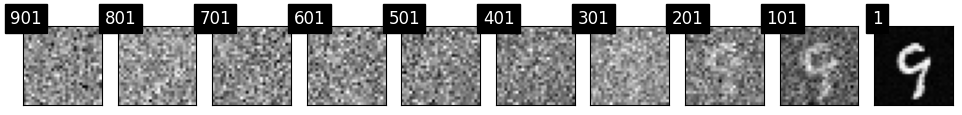

In [47]:
# 可视化  
def show_sample(images, texts):
    _, figs= plt.subplots(1, len(images), figsize= (12, 12))
    for text, f, img in zip(texts, figs, images):
        f.imshow(img.view(28, 28), cmap= 'gray')
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
        f.text(0.5, 0, text, ha= 'center', va= 'bottom', fontsize= 12, color= 'white', backgroundcolor= 'black')
    plt.show()
import warnings
warnings.filterwarnings("ignore")  
xt, images, texts= torch.randn((1, 1, 28, 28), device= device), [], []
u_net= torch.load(f'{save_dir}')
dm= DenoiseDiffusion(u_net, 1000, device= device)
for t in reversed(range(1000)):
    xt_1= dm.p_sample(xt, torch.tensor([t]).to(device))
    xt= xt_1
    if (t+ 1)% 100== 1:
        images.append(xt.view(1, 28, 28).to('cpu').detach())
        texts.append(t+ 1)
        
images_= torch.stack(images, dim= 0)
show_sample(images_, texts)    

__可以看出效果越来越好，但是存在一个很明显的问题，就是这个代码要跑好几个小时，因此再尝试Diffusion Model的改进__
<a id="5"></a>
## 八、隐扩散模型（Latent Diffusion Model）
使用变分自编码器VAE作为encoder和decoder的ldm
### 8.1 辅助函数定义与模型定义
自注意力、交叉注意力、VAE注意力、VAE残差、VAEenconder、VAEdecoder、VAE、UNet注意力

In [3]:
## Latent Diffusion Model（潜扩散模型）
# 收敛速度更快

# 自注意力
class SelfAttention(nn.Module):
    def __init__(self, n_heads: torch.tensor, d_embed: torch.tensor):
        super().__init__()
        self.in_proj= nn.Linear(d_embed, 3* d_embed, bias= True)
        self.out_proj= nn.Linear(d_embed, d_embed)
        self.d_embed= d_embed
        self.n_heads= n_heads
    def forward(self, x: torch.tensor, causal_mask=False)-> torch.tensor:
        b, l, d= x.shape
        # x, (batch_size, len, dim)>> (batch_size, len, 3* dim)>> (batch_size, len, head, dim// head* 3)
        x_proj= self.in_proj(x).view(b, l, self.n_heads, -1)
        # q, k or v, (batch_size, len, head, dim// head)
        q, k, v= x_proj.chunk(3, dim= -1)
        # att, (batch_size, len, len, head)
        att= torch.einsum('blhd, bmhd->blmh', q, k)/ math.sqrt(self.d_embed// self.n_heads)
        # mask
        if causal_mask:
            mask= torch.ones_like(att, dtype=torch.bool).triu(1) 
            att.masked_fill_(mask, -torch.inf)
        att= torch.softmax(att, dim= 2)
        opt= torch.einsum('blmh, blhd-> blhd', att, v).view(b, l, d)
        return self.out_proj(opt) 
    
# 
class CrossAttention(nn.Module):
    def __init__(self, n_heads: torch.tensor, d_embed: torch.tensor, d_cross: torch.tensor):
        super().__init__()
        self.q_proj= nn.Linear(d_embed, d_embed, bias= True)
        self.kv_proj= nn.Linear(d_cross, 2* d_embed, bias= True)
        self.out_proj= nn.Linear(d_embed, d_embed, bias= True)
        self.n_heads= n_heads
        self.d_embed= d_embed
    def forward(self, x: torch.tensor, y: torch.tensor)-> torch.tensor:
        b, l, d= x.shape
        # x, (batch_size, seq_len, d_embed)-> (b, l, h, d//h), y, (batch_size, seq_len, d_cross)
        q= self.q_proj(x).view(b, l, self.n_heads, -1)
        # y, (batch_size, seq_len, 2* d_embed)-> (b, l, h, 2* d// h)-> k, v, (b, l, h, d// h)
        k, v= self.kv_proj(y).view(b, y.shape[1], self.n_heads, -1).chunk(2, dim= -1)
        att= torch.softmax(torch.einsum('blhd, bmhd-> blmh', q, k)/ (self.d_embed// self.n_heads)** 0.5, dim= 2)
        return self.out_proj(torch.einsum('blmh, bmhd-> blhd', att, v).reshape(b, l, d))
    
# 
class VAE_AttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.groupnorm = nn.GroupNorm(32, channels)
        self.attention = SelfAttention(1, channels)
    def forward(self, x):
        # x: (Batch_Size, Features, Height, Width)
        residue= x 
        x= self.groupnorm(x)
        n, c, h, w= x.shape
        x= x.view((n, c, h * w))
        # (Batch_Size, Features, Height * Width) -> (Batch_Size, Height * Width, Features). Each pixel becomes a feature of size "Features", the sequence length is "Height * Width".
        x= x.transpose(-1, -2)
        x= self.attention(x)
        x= x.transpose(-1, -2)
        # (Batch_Size, Features, Height * Width) -> (Batch_Size, Features, Height, Width)
        x= x.view((n, c, h, w))
        # (Batch_Size, Features, Height, Width)
        return x+ residue 
    
#
class VAE_ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.groupnorm_1= nn.GroupNorm(32, in_channels)
        self.conv_1= nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.groupnorm_2= nn.GroupNorm(32, out_channels)
        self.conv_2= nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        if in_channels == out_channels:
            self.residual_layer = nn.Identity()
        else:
            self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
    def forward(self, x):
        # x: (Batch_Size, In_Channels, Height, Width)
        residue= x
        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, In_Channels, Height, Width)
        x= self.groupnorm_1(x)
        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, In_Channels, Height, Width)
        x= F.silu(x)
        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        x= self.conv_1(x)
        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        x= self.groupnorm_2(x)
        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        x= F.silu(x)
        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        x= self.conv_2(x)
        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        return x+ self.residual_layer(residue)
    
#
class VAE_Encoder(nn.Sequential):
    def __init__(self, device= 'cpu'):
        super().__init__(
            # Batch_size, B; Channel, C; Height, H; Weight, W.
            # (B, 1, H, W)-> (B, 128, H, W)
            nn.Conv2d(1, 64, kernel_size= 3, padding= 1),
            VAE_ResidualBlock(64, 64),
            # (B, 128, H, W)-> (B, 128, H/ 2, W/ 2)
            nn.Conv2d(64, 64, kernel_size= 3, stride= 2),
            # up channel
            VAE_ResidualBlock(64, 64),
            # (B, 128, H/ 2, W/ 2)-> (B, 256, H/ 4, W/ 4)
            nn.Conv2d(64, 128, kernel_size= 3, stride= 2),
            VAE_AttentionBlock(128),
            VAE_ResidualBlock(128, 128),
            nn.GroupNorm(32, 128),
            nn.SiLU(),
            nn.Conv2d(128, 8, kernel_size= 3, padding= 1),
            # output, (B, 8, H/ 4, W/ 4)
            nn.Conv2d(8, 8, kernel_size= 1, padding= 0)
        )
        self.norm_dist= torch.distributions.Normal(0, 1)
        self.device= device
    def forward(self, x):
        # transform x into latent code.
        # x, (B, 1, H, W)-> (B, 8, H/ 4, W/ 4)
        for module in self:
            # confirm H/ 2
            if getattr(module, 'stride', None)== (2, 2):
                x= F.pad(x, (0, 1, 0, 1))
            x= module(x)
        # maen, (B, 4, H/ 4, W/ 4); log_var, (B, 4, H/ 4, W/ 4)
        maen, log_var= torch.chunk(x, 2, dim= 1)
        var_= torch.clamp(log_var, -30, 20).exp()
        stdev= var_** 0.5
        z= self.norm_dist.sample(maen.shape).to(self.device)* stdev+ maen
        return maen, stdev, z
    
# 
class VAE_Decoder(nn.Sequential):
    def __init__(self):
        super().__init__(
            # (B, 4, H/ 4, W/ 4)-> (B, 256, H/ 4, W/ 4)
            nn.Conv2d(4, 128, kernel_size= 1, padding= 0),
            nn.Conv2d(128, 128, kernel_size= 3, padding= 1),
            VAE_AttentionBlock(128),
            VAE_ResidualBlock(128, 128),
            # (B, 256, H/ 4, W/ 4)-> (B, 256, H/ 2, W/ 2)
            nn.Upsample(scale_factor= 2),
            # (B, 256, H/ 2, W/ 2)-> (B, 128, H/ 2, W/ 2)
            nn.Conv2d(128, 64, kernel_size= 3, padding= 1),
            VAE_ResidualBlock(64, 64),
            # (B, 128, H/ 2, W/ 2)-> (B, 128, H, W)
            nn.Upsample(scale_factor= 2),
            nn.Conv2d(64, 64, kernel_size= 3, padding= 1),
            VAE_ResidualBlock(64, 64),
            nn.GroupNorm(32, 64),
            nn.SiLU(),
            nn.Conv2d(64, 1, kernel_size= 3, padding= 1)
        )
    def forward(self, x):
        for module in self:
            x= module(x)
        return x
    
#
class VAE(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device= device
        self.encoder= VAE_Encoder().to(device)
        self.decoder= VAE_Decoder().to(device)
    def loss_fuc(self, pred, label, mu, sga, balance_factor= 0.05, eps= 1e-10):
        return ((pred- label)** 2).mean()+ balance_factor* (sga** 2+ mu** 2- torch.log(sga+ eps)- 0.5).mean()
    def forward(self, x):
        mu, sga, z= self.encoder(x)
        return mu, sga, self.decoder(z)

#
class UNet_ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, d_time= 128):
        super().__init__()
        self.gn_feat= nn.GroupNorm(32, in_channels)
        self.cv_feat= nn.Conv2d(in_channels, out_channels, kernel_size= 3, padding= 1)
        self.lin_time= nn.Linear(d_time, out_channels)
        self.gn_merged= nn.GroupNorm(32, out_channels)
        self.cv_merged= nn.Conv2d(out_channels, out_channels, kernel_size= 3, padding= 1)
        if in_channels== out_channels:
            self.residual_layer= nn.Identity()
        else:
            self.residual_layer= nn.Conv2d(in_channels, out_channels, kernel_size= 1, padding= 0)
    def forward(self, feat, t):
        # feat, (B, C_in, H, W), t, (B, n_time)
        residual_= feat
        feat= F.silu(self.gn_feat(feat))
        # (B, C_in, H, W)-> (B, C_out, H, W)
        feat= F.silu(self.cv_feat(feat))
        # (B, C_out, H, W)+ (B, C_out, 1, 1)
        feat+= self.lin_time(F.silu(t))[:, :, None, None]
        # (B, C_out, H, W)-> (B, C_out, H, W)
        feat= self.cv_merged(F.silu(self.gn_merged(feat)))
        # feat, (B, C_out, H, W)
        return feat+ self.residual_layer(residual_)

#
class UNet_AttentionBlock(nn.Module):
    # n_dims can adapt to the number of the heads
    def __init__(self, n_channels: int, n_heads: int, n_dims: int= None, n_groups: int= 32):
        super().__init__()
        if n_dims is None:n_dims= n_channels
        self.gn= nn.GroupNorm(n_groups, n_channels)
        self.proj= nn.Linear(n_channels, n_dims* 3)
        self.output= nn.Linear(n_dims, n_channels)
        self.scale= n_dims** -0.5
        self.n_heads= n_heads
        self.n_dims= n_dims
    def forward(self, x: torch.tensor, t: Optional[torch.tensor]= None):
        _= t
        b, c, h, w= x.shape
        # (B, C, H, W)-> (B, H* W, C)
        x= x.view(b, c, h* w).permute(0, 2, 1)
        # (B, H* W, C)-> (B, H* W, 3* C)-> (B, seq_len, h, dim)
        q, k, v= self.proj(x).view(b, h* w, self.n_heads, -1).chunk(3, dim= -1)
        att= torch.einsum('blhd, bmhd-> blmh', q, k)/ self.scale
        att= torch.softmax(att, dim= -2)
        x_= torch.einsum('blmh, blhd-> blhd', att, v)
        x_= self.output(x_.view(b, h* w, -1))+ x
        # (B, C, H, W)
        return x.permute(0, 2, 1).view(b, c, h, w)
    
#
class SwitchSequential(nn.Sequential):
    def forward(self, x, t):
        for layer in self:
            if isinstance(layer, UNet_AttentionBlock) or isinstance(layer, UNet_ResidualBlock):
                x= layer(x, t)
            else:
                x= layer(x)
        return x
       
#
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder= nn.ModuleList([
            # (B, 4, H/ 4, W/ 4)-> (B, 64, H/ 4, W/ 4)
            SwitchSequential(nn.Conv2d(4, 64, kernel_size= 3, padding= 1)),
            SwitchSequential(UNet_ResidualBlock(64, 64), UNet_AttentionBlock(64, 8, 40)),
            SwitchSequential(UNet_ResidualBlock(64, 64), UNet_AttentionBlock(64, 8, 40)),
            # (B, 64, H/ 4, W/ 4)-> (B, 128, H/ 8, W/ 8)
            SwitchSequential(nn.Conv2d(64, 128, kernel_size= 3, stride= 2, padding= 1)),
            SwitchSequential(UNet_ResidualBlock(128, 128), UNet_AttentionBlock(128, 8, 80)),
            SwitchSequential(UNet_ResidualBlock(128, 128), UNet_AttentionBlock(128, 8, 80)),
            # (B, 128, H/ 8, W/ 8)-> (B, 256, H/ 16, W/ 16)
            SwitchSequential(nn.Conv2d(128, 256, kernel_size= 3, stride= 2, padding= 1)),
            SwitchSequential(UNet_ResidualBlock(256, 256), UNet_AttentionBlock(256, 8, 120)),
            SwitchSequential(UNet_ResidualBlock(256, 256), UNet_AttentionBlock(256, 8, 120)),
            # (B, 256, H/ 16, W/ 16)-> (B, 256, H/ 16, W/ 16)
            SwitchSequential(nn.Conv2d(256, 256, kernel_size= 3, padding= 1)),
            SwitchSequential(UNet_ResidualBlock(256, 256)),
            SwitchSequential(UNet_ResidualBlock(256, 256))
        ])
        self.bottleneck= SwitchSequential(
            UNet_ResidualBlock(256, 256),
            UNet_AttentionBlock(256, 8, 120),
            UNet_ResidualBlock(256, 256)
        )
        self.decoder= nn.ModuleList([
            SwitchSequential(UNet_ResidualBlock(512, 256)),
            SwitchSequential(UNet_ResidualBlock(512, 256)),
            SwitchSequential(nn.ConvTranspose2d(512, 256, kernel_size= 3, padding= 1)),
            SwitchSequential(UNet_ResidualBlock(512, 256), UNet_AttentionBlock(256, 8, 120)),
            SwitchSequential(UNet_ResidualBlock(512, 256), UNet_AttentionBlock(256, 8, 120)),
            SwitchSequential(nn.ConvTranspose2d(512, 256, 4, 2, 1)),
            SwitchSequential(UNet_ResidualBlock(384, 128), UNet_AttentionBlock(128, 8, 80)),
            SwitchSequential(UNet_ResidualBlock(256, 128), UNet_AttentionBlock(128, 8, 80)),
            SwitchSequential(nn.ConvTranspose2d(256, 128, 3, 2, 1)),
            SwitchSequential(UNet_ResidualBlock(192, 64), UNet_AttentionBlock(64, 8, 40)),
            SwitchSequential(UNet_ResidualBlock(128, 64), UNet_AttentionBlock(64, 8, 40)),
            SwitchSequential(nn.ConvTranspose2d(128, 4, 3, padding= 1))
        ])
        self.time_emb= TimeEmbedding(n_channels= 128)
    def forward(self, x, t):
        t= self.time_emb(t)
        skip_cont= []
        for layer in self.encoder:
            x= layer(x, t)
            skip_cont.append(x)
        x= self.bottleneck(x, t)
        for layer in self.decoder:
            x= torch.cat([x, skip_cont.pop()], dim= 1)
            x= layer(x, t)
        return x

### 8.2 VAE训练
__CPU实在带不动了  只能上小样本了__  
由于这个LDM是基于VAE的所以先训练VAE

In [4]:
# 预训练样本，取1/100
total_samples = len(train_loader.dataset)
subset_size = total_samples // 100
subset_dataset = torch.utils.data.Subset(train_loader.dataset, range(subset_size))
subset_train_loader = torch.utils.data.DataLoader(subset_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

total_samples = len(valid_loader.dataset)
subset_size = total_samples // 100
subset_dataset = torch.utils.data.Subset(valid_loader.dataset, range(subset_size))
subset_valid_loader = torch.utils.data.DataLoader(subset_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

# 模型训练
lr, device, vae_save_path, epoch, patience= 1e-3, 'cpu', './vae.pt', 10, 20
net= VAE(device).to(device)
optimizer= torch.optim.Adam(net.parameters(), lr= lr)

early_stopping_time, hist_val, early_stopping_flag= 0, 1e4, False
for ep in tqdm(range(epoch)):
    loss_rec= []
    for step, (pics, labels) in enumerate(subset_train_loader):
        pics= pics.view(pics.shape[0], 1, 28, 28).to(device)
        mu, sga, pics_rec= net(pics)
        optimizer.zero_grad()
        loss= net.loss_fuc(pics_rec, pics, mu, sga)
        loss_rec.append(loss.item())
        loss.backward()
        optimizer.step()
    print(f'training epoch: {ep+ 1}, mean loss: {torch.tensor(loss_rec).mean()}')
    loss_rec.clear()
    with torch.no_grad():
        for step, (pics, labels) in tqdm(enumerate(subset_valid_loader), total=len(subset_valid_loader)):
            pics= pics.view(pics.shape[0], 1, 28, 28).to(device)
            mu, sga, pics_rec= net(pics)
            loss_rec.append(net.loss_fuc(pics_rec, pics, mu, sga))
        loss_val= torch.tensor(loss_rec).mean()
    if loss_val< hist_val:
        torch.save(net, vae_save_path)
        hist_val= loss_val
        es_time= 0
    else:
        es_time+= 1
        early_stopping_flag= [False, True][es_time>= patience]
    if early_stopping_flag:break
    print(f'early_stop_time/early_stop_threshold: {es_time+ 1}/{patience}, mean loss: {loss_val}')
    

  0%|                                                    | 0/10 [00:00<?, ?it/s]

training epoch: 1, mean loss: 0.23184871673583984



%|                                                     | 0/1 [00:00<?, ?it/s]
 10%|████▍                                       | 1/10 [00:07<01:07,  7.53s/it]

early_stop_time/early_stop_threshold: 1/20, mean loss: 0.6667112708091736
training epoch: 2, mean loss: 0.6638250350952148



%|                                                     | 0/1 [00:00<?, ?it/s]
 20%|████████▊                                   | 2/10 [00:14<00:58,  7.34s/it]

early_stop_time/early_stop_threshold: 1/20, mean loss: 0.1684112846851349
training epoch: 3, mean loss: 0.17097491025924683



%|                                                     | 0/1 [00:00<?, ?it/s]
 30%|█████████████▏                              | 3/10 [00:22<00:51,  7.31s/it]

early_stop_time/early_stop_threshold: 1/20, mean loss: 0.1328941285610199
training epoch: 4, mean loss: 0.13767370581626892



%|                                                     | 0/1 [00:00<?, ?it/s]
 40%|█████████████████▌                          | 4/10 [00:29<00:43,  7.19s/it]

early_stop_time/early_stop_threshold: 1/20, mean loss: 0.09943823516368866
training epoch: 5, mean loss: 0.10215818881988525



%|                                                     | 0/1 [00:00<?, ?it/s]
 50%|██████████████████████                      | 5/10 [00:35<00:35,  7.08s/it]

early_stop_time/early_stop_threshold: 1/20, mean loss: 0.09539468586444855
training epoch: 6, mean loss: 0.09804395586252213



%|                                                     | 0/1 [00:00<?, ?it/s]
 60%|██████████████████████████▍                 | 6/10 [00:43<00:29,  7.31s/it]

early_stop_time/early_stop_threshold: 2/20, mean loss: 0.09577389061450958
training epoch: 7, mean loss: 0.09818962961435318



%|                                                     | 0/1 [00:00<?, ?it/s]
 70%|██████████████████████████████▊             | 7/10 [00:50<00:21,  7.27s/it]

early_stop_time/early_stop_threshold: 1/20, mean loss: 0.09422247111797333
training epoch: 8, mean loss: 0.09651018679141998



%|                                                     | 0/1 [00:00<?, ?it/s]
 80%|███████████████████████████████████▏        | 8/10 [00:57<00:14,  7.16s/it]

early_stop_time/early_stop_threshold: 1/20, mean loss: 0.090964674949646
training epoch: 9, mean loss: 0.09348058700561523



%|                                                     | 0/1 [00:00<?, ?it/s]
 90%|███████████████████████████████████████▌    | 9/10 [01:04<00:07,  7.05s/it]

early_stop_time/early_stop_threshold: 1/20, mean loss: 0.0887884721159935
training epoch: 10, mean loss: 0.09134630858898163



%|                                                     | 0/1 [00:00<?, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:11<00:00,  7.15s/it]

early_stop_time/early_stop_threshold: 1/20, mean loss: 0.08670082688331604


### 8.3 基于VAE的隐扩散模型训练

In [5]:
## 
lr, device, unet_save_path, patience, epochs= 0.001, 'cpu', './u_net.pt', 10, 30
vae= torch.load(vae_save_path).to(device)
u_net= UNet().to(device)
dm= DenoiseDiffusion(u_net, 1000, device= device)
opt_dm= torch.optim.Adam(u_net.parameters(), lr= lr)

import warnings
warnings.filterwarnings("ignore") 

best_score, score, early_stop_time= 1e10, 0, 0
for epoch in range(epochs):
    loss_record= []
    for step, (pic, labels) in enumerate(subset_train_loader):
        pic= pic.view(-1, 1, 28, 28).to(device)
        _, _, latent= vae.encoder(pic)
        loss= dm.loss(latent)
        opt_dm.zero_grad()
        loss_record.append(loss.item())
        loss.backward()
        opt_dm.step()
    print(f'training epoch: {epoch+ 1}, mean loss: {torch.tensor(loss_record).mean()}')
    loss_record= []
    with torch.no_grad():
        for step, (pic, labels) in tqdm(enumerate(subset_valid_loader), total=len(subset_valid_loader)):
            pic= pic.view(-1, 1, 28, 28).to(device)
            _, _, latent= vae.encoder(pic)
            loss= dm.loss(latent)
            loss_record.append(loss.item()) 
    mean_loss= torch.tensor(loss_record).mean()
    # early stopping
    if mean_loss< best_score:
        early_stop_time= 0
        best_score= mean_loss
        torch.save(u_net, f'{unet_save_path}')
    else:
        early_stop_time= early_stop_time+ 1
    if early_stop_time> patience:break
    # output
    print(f'early_stop_time/early_stop_threshold: {early_stop_time+ 1}/{patience}, mean loss: {mean_loss}')

/var/folders/nk/ybyq6yb13njgrdf270gg6j2m0000gn/T/ipykernel_72485/2285908400.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae= torch.load(vae_save_path).to(device)


training epoch: 1, mean loss: 3.501279592514038


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]


early_stop_time/early_stop_threshold: 1/10, mean loss: 4.751610279083252
training epoch: 2, mean loss: 4.867320537567139


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


early_stop_time/early_stop_threshold: 1/10, mean loss: 2.117521047592163
training epoch: 3, mean loss: 2.1395745277404785


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


early_stop_time/early_stop_threshold: 2/10, mean loss: 2.3124077320098877
training epoch: 4, mean loss: 2.3076696395874023


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


early_stop_time/early_stop_threshold: 1/10, mean loss: 1.4492779970169067
training epoch: 5, mean loss: 1.420318603515625


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


early_stop_time/early_stop_threshold: 1/10, mean loss: 1.1279503107070923
training epoch: 6, mean loss: 1.1334296464920044


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.10it/s]


early_stop_time/early_stop_threshold: 1/10, mean loss: 1.0436736345291138
training epoch: 7, mean loss: 1.0835856199264526


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


early_stop_time/early_stop_threshold: 1/10, mean loss: 0.8899039030075073
training epoch: 8, mean loss: 0.8234578967094421


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


early_stop_time/early_stop_threshold: 1/10, mean loss: 0.7896629571914673
training epoch: 9, mean loss: 0.8751149773597717


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.10it/s]


early_stop_time/early_stop_threshold: 1/10, mean loss: 0.7825382351875305
training epoch: 10, mean loss: 0.803773820400238


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]


early_stop_time/early_stop_threshold: 1/10, mean loss: 0.6955994367599487
training epoch: 11, mean loss: 0.7096366882324219


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


early_stop_time/early_stop_threshold: 1/10, mean loss: 0.672765851020813
training epoch: 12, mean loss: 0.6827582716941833


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


early_stop_time/early_stop_threshold: 2/10, mean loss: 0.6943359971046448
training epoch: 13, mean loss: 0.6396259665489197


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


early_stop_time/early_stop_threshold: 1/10, mean loss: 0.5988482236862183
training epoch: 14, mean loss: 0.6149488687515259


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.97it/s]


early_stop_time/early_stop_threshold: 1/10, mean loss: 0.5880540013313293
training epoch: 15, mean loss: 0.5754149556159973


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]


early_stop_time/early_stop_threshold: 1/10, mean loss: 0.5609487295150757
training epoch: 16, mean loss: 0.5332186222076416


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


early_stop_time/early_stop_threshold: 1/10, mean loss: 0.5112399458885193
training epoch: 17, mean loss: 0.5586557984352112


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


early_stop_time/early_stop_threshold: 2/10, mean loss: 0.5169371962547302
training epoch: 18, mean loss: 0.5175048112869263


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


early_stop_time/early_stop_threshold: 3/10, mean loss: 0.5485827326774597
training epoch: 19, mean loss: 0.4841644763946533


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.86it/s]


early_stop_time/early_stop_threshold: 1/10, mean loss: 0.4350171387195587
training epoch: 20, mean loss: 0.5206989645957947


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


early_stop_time/early_stop_threshold: 2/10, mean loss: 0.5757750868797302
training epoch: 21, mean loss: 0.47067368030548096


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


early_stop_time/early_stop_threshold: 3/10, mean loss: 0.46834516525268555
training epoch: 22, mean loss: 0.4657660126686096


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]


early_stop_time/early_stop_threshold: 4/10, mean loss: 0.45957595109939575
training epoch: 23, mean loss: 0.47960615158081055


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.94it/s]


early_stop_time/early_stop_threshold: 5/10, mean loss: 0.4447556436061859
training epoch: 24, mean loss: 0.4549770951271057


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


early_stop_time/early_stop_threshold: 6/10, mean loss: 0.5310355424880981
training epoch: 25, mean loss: 0.41806378960609436


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


early_stop_time/early_stop_threshold: 7/10, mean loss: 0.45515015721321106
training epoch: 26, mean loss: 0.4079248905181885


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


early_stop_time/early_stop_threshold: 1/10, mean loss: 0.4156506359577179
training epoch: 27, mean loss: 0.4094531834125519


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


early_stop_time/early_stop_threshold: 2/10, mean loss: 0.5346267819404602
training epoch: 28, mean loss: 0.400375634431839


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


early_stop_time/early_stop_threshold: 1/10, mean loss: 0.387978732585907
training epoch: 29, mean loss: 0.4021041691303253


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


early_stop_time/early_stop_threshold: 2/10, mean loss: 0.40200275182724
training epoch: 30, mean loss: 0.4326019287109375


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]

early_stop_time/early_stop_threshold: 1/10, mean loss: 0.3680298626422882


### 8.4 小样本模型应用

sample 1 image, denoising...


1000it [00:15, 65.27it/s]


sample 2 image, denoising...


1000it [00:15, 66.58it/s]


sample 3 image, denoising...


1000it [00:14, 67.19it/s]


sample 4 image, denoising...


1000it [00:18, 55.13it/s]


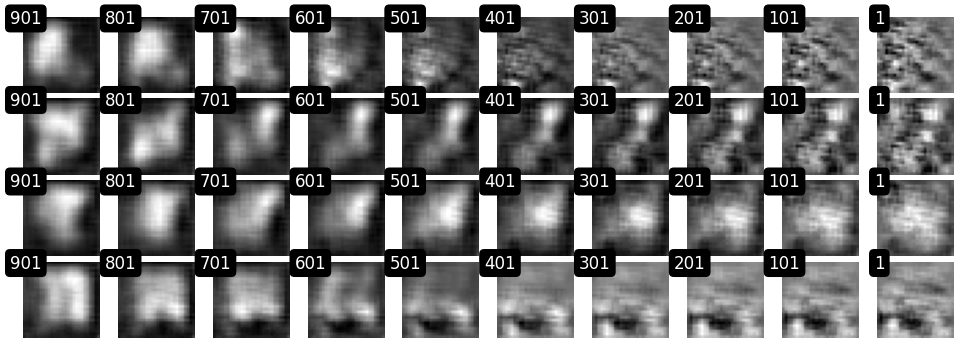

In [6]:
def show_sample2d(images, texts):   
    num_rows = len(images)
    num_cols = len(images[0]) if images else 0
    _, figs = plt.subplots(num_rows, num_cols, figsize=(12, 12))
    for i in range(num_rows):  
        for j in range(num_cols):  
            f, img, text= figs[i][j], images[i][j], texts[i][j]
            img = img.view(28, 28)
            f.imshow(img, cmap='gray')
            f.axis('off')
            f.text(0.5, 0.05, text, ha='center', va='center', fontsize=12,   
                   color='white', backgroundcolor='black', bbox=dict(facecolor='black', edgecolor='none', boxstyle='round'))  
    plt.subplots_adjust(wspace=0.24, hspace=-0.88)
    plt.show()
    
vae, u_net= torch.load(vae_save_path), torch.load(unet_save_path)
dm= DenoiseDiffusion(u_net, 1000, device= device)
from tqdm import tqdm
test_pic_num= 4
images, texts= [], []
for i in range(test_pic_num):
    images_, texts_= [], []
    print(f'sample {i+ 1} image, denoising...')
    xt= torch.randn((1, 4, 7, 7), device= device)
    for t in tqdm(reversed(range(1000))):
        xt_1= dm.p_sample(xt, torch.tensor([t]).to(device))
        xt= xt_1
        if (t+ 1)% 100== 1:
            denoising_pic= vae.decoder(xt)
            images_.append(denoising_pic.view(1, 28, 28).to('cpu').detach())
            texts_.append(t+ 1)
    images.append(images_)
    texts.append(texts_)
    
show_sample2d(images, texts)
    

### 8.5 全样本训练
#### 8.5.1 训练VAE

In [7]:
# 全部样本
total_samples = len(train_loader.dataset)
subset_size = total_samples // 100
subset_dataset = torch.utils.data.Subset(train_loader.dataset, range(subset_size))
subset_train_loader = torch.utils.data.DataLoader(subset_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

total_samples = len(valid_loader.dataset)
subset_size = total_samples // 100
subset_dataset = torch.utils.data.Subset(valid_loader.dataset, range(subset_size))
subset_valid_loader = torch.utils.data.DataLoader(subset_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

# 模型训练
lr, device, vae_save_path, epoch, patience= 1e-3, 'cpu', './vae.pt', 10, 20
net= VAE(device).to(device)
optimizer= torch.optim.Adam(net.parameters(), lr= lr)

early_stopping_time, hist_val, early_stopping_flag= 0, 1e4, False
for ep in tqdm(range(epoch)):
    loss_rec= []
    for step, (pics, labels) in enumerate(subset_train_loader):
        pics= pics.view(pics.shape[0], 1, 28, 28).to(device)
        mu, sga, pics_rec= net(pics)
        optimizer.zero_grad()
        loss= net.loss_fuc(pics_rec, pics, mu, sga)
        loss_rec.append(loss.item())
        loss.backward()
        optimizer.step()
    print(f'training epoch: {ep+ 1}, mean loss: {torch.tensor(loss_rec).mean()}')
    loss_rec.clear()
    with torch.no_grad():
        for step, (pics, labels) in tqdm(enumerate(subset_valid_loader), total=len(subset_valid_loader)):
            pics= pics.view(pics.shape[0], 1, 28, 28).to(device)
            mu, sga, pics_rec= net(pics)
            loss_rec.append(net.loss_fuc(pics_rec, pics, mu, sga))
        loss_val= torch.tensor(loss_rec).mean()
    if loss_val< hist_val:
        torch.save(net, vae_save_path)
        hist_val= loss_val
        es_time= 0
    else:
        es_time+= 1
        early_stopping_flag= [False, True][es_time>= patience]
    if early_stopping_flag:break
    print(f'early_stop_time/early_stop_threshold: {es_time+ 1}/{patience}, mean loss: {loss_val}')
    

  0%|                                                    | 0/10 [00:00<?, ?it/s]

training epoch: 1, mean loss: 0.23487676680088043



%|                                                     | 0/1 [00:00<?, ?it/s]
 10%|████▍                                       | 1/10 [00:16<02:31, 16.78s/it]

early_stop_time/early_stop_threshold: 1/20, mean loss: 0.7421199083328247
training epoch: 2, mean loss: 0.7469435334205627



%|                                                     | 0/1 [00:00<?, ?it/s]
 20%|████████▊                                   | 2/10 [00:26<01:38, 12.34s/it]

early_stop_time/early_stop_threshold: 1/20, mean loss: 0.1698259711265564
training epoch: 3, mean loss: 0.17109927535057068



%|                                                     | 0/1 [00:00<?, ?it/s]
 30%|█████████████▏                              | 3/10 [00:35<01:16, 10.96s/it]

early_stop_time/early_stop_threshold: 1/20, mean loss: 0.15297579765319824
training epoch: 4, mean loss: 0.15553060173988342



%|                                                     | 0/1 [00:00<?, ?it/s]
 40%|█████████████████▌                          | 4/10 [00:44<01:01, 10.17s/it]

early_stop_time/early_stop_threshold: 1/20, mean loss: 0.11662465333938599
training epoch: 5, mean loss: 0.11930122971534729



%|                                                     | 0/1 [00:00<?, ?it/s]
 50%|██████████████████████                      | 5/10 [00:52<00:47,  9.58s/it]

early_stop_time/early_stop_threshold: 1/20, mean loss: 0.10034593939781189
training epoch: 6, mean loss: 0.10412896424531937



%|                                                     | 0/1 [00:00<?, ?it/s]
 60%|██████████████████████████▍                 | 6/10 [01:00<00:35,  8.97s/it]

early_stop_time/early_stop_threshold: 1/20, mean loss: 0.09560853242874146
training epoch: 7, mean loss: 0.0981583371758461



%|                                                     | 0/1 [00:00<?, ?it/s]
 70%|██████████████████████████████▊             | 7/10 [01:13<00:30, 10.17s/it]

early_stop_time/early_stop_threshold: 2/20, mean loss: 0.0988219603896141
training epoch: 8, mean loss: 0.10080701112747192



%|                                                     | 0/1 [00:00<?, ?it/s]
 80%|███████████████████████████████████▏        | 8/10 [01:22<00:19,  9.87s/it]

early_stop_time/early_stop_threshold: 3/20, mean loss: 0.09737485647201538
training epoch: 9, mean loss: 0.09919784218072891



%|                                                     | 0/1 [00:00<?, ?it/s]
 90%|███████████████████████████████████████▌    | 9/10 [01:31<00:09,  9.51s/it]

early_stop_time/early_stop_threshold: 1/20, mean loss: 0.09205033630132675
training epoch: 10, mean loss: 0.09470991045236588



%|                                                     | 0/1 [00:00<?, ?it/s]
100%|███████████████████████████████████████████| 10/10 [01:39<00:00,  9.97s/it]

early_stop_time/early_stop_threshold: 1/20, mean loss: 0.08902022987604141


#### 8.5.2 训练LDM

In [8]:
## 
lr, device, unet_save_path, patience, epochs= 0.001, 'cpu', './u_net.pt', 15, 100
vae= torch.load(vae_save_path).to(device)
u_net= UNet().to(device)
dm= DenoiseDiffusion(u_net, 1000, device= device)
opt_dm= torch.optim.Adam(u_net.parameters(), lr= lr)

import warnings
warnings.filterwarnings("ignore") 

best_score, score, early_stop_time= 1e10, 0, 0
for epoch in range(epochs):
    loss_record= []
    for step, (pic, labels) in enumerate(subset_train_loader):
        pic= pic.view(-1, 1, 28, 28).to(device)
        _, _, latent= vae.encoder(pic)
        loss= dm.loss(latent)
        opt_dm.zero_grad()
        loss_record.append(loss.item())
        loss.backward()
        opt_dm.step()
    print(f'training epoch: {epoch+ 1}, mean loss: {torch.tensor(loss_record).mean()}')
    loss_record= []
    with torch.no_grad():
        for step, (pic, labels) in tqdm(enumerate(subset_valid_loader), total=len(subset_valid_loader)):
            pic= pic.view(-1, 1, 28, 28).to(device)
            _, _, latent= vae.encoder(pic)
            loss= dm.loss(latent)
            loss_record.append(loss.item()) 
    mean_loss= torch.tensor(loss_record).mean()
    # early stopping
    if mean_loss< best_score:
        early_stop_time= 0
        best_score= mean_loss
        torch.save(u_net, f'{unet_save_path}')
    else:
        early_stop_time= early_stop_time+ 1
    if early_stop_time> patience:break
    # output
    print(f'early_stop_time/early_stop_threshold: {early_stop_time+ 1}/{patience}, mean loss: {mean_loss}')

training epoch: 1, mean loss: 3.057793140411377


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


early_stop_time/early_stop_threshold: 1/15, mean loss: 10.186372756958008
training epoch: 2, mean loss: 10.07589340209961


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.59it/s]


early_stop_time/early_stop_threshold: 1/15, mean loss: 2.116244316101074
training epoch: 3, mean loss: 2.154390811920166


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


early_stop_time/early_stop_threshold: 1/15, mean loss: 1.6816997528076172
training epoch: 4, mean loss: 1.6866848468780518


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


early_stop_time/early_stop_threshold: 1/15, mean loss: 1.4961978197097778
training epoch: 5, mean loss: 1.4981356859207153


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


early_stop_time/early_stop_threshold: 1/15, mean loss: 1.2720019817352295
training epoch: 6, mean loss: 1.1155911684036255


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


early_stop_time/early_stop_threshold: 1/15, mean loss: 1.0259274244308472
training epoch: 7, mean loss: 1.0749894380569458


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


early_stop_time/early_stop_threshold: 1/15, mean loss: 0.9259888529777527
training epoch: 8, mean loss: 0.90776526927948


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


early_stop_time/early_stop_threshold: 1/15, mean loss: 0.761914849281311
training epoch: 9, mean loss: 0.7828407287597656


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


early_stop_time/early_stop_threshold: 1/15, mean loss: 0.7271085381507874
training epoch: 10, mean loss: 0.7774141430854797


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


early_stop_time/early_stop_threshold: 2/15, mean loss: 0.7745391130447388
training epoch: 11, mean loss: 0.7475771307945251


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


early_stop_time/early_stop_threshold: 1/15, mean loss: 0.7188863754272461
training epoch: 12, mean loss: 0.6767619252204895


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


early_stop_time/early_stop_threshold: 1/15, mean loss: 0.7006993293762207
training epoch: 13, mean loss: 0.6481942534446716


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


early_stop_time/early_stop_threshold: 1/15, mean loss: 0.6916806697845459
training epoch: 14, mean loss: 0.6269997954368591


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


early_stop_time/early_stop_threshold: 1/15, mean loss: 0.6034054756164551
training epoch: 15, mean loss: 0.6239270567893982


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


early_stop_time/early_stop_threshold: 2/15, mean loss: 0.6113083362579346
training epoch: 16, mean loss: 0.591859757900238


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


early_stop_time/early_stop_threshold: 1/15, mean loss: 0.5804566740989685
training epoch: 17, mean loss: 0.5598793029785156


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


early_stop_time/early_stop_threshold: 2/15, mean loss: 0.5934040546417236
training epoch: 18, mean loss: 0.5060200095176697


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


early_stop_time/early_stop_threshold: 1/15, mean loss: 0.46677425503730774
training epoch: 19, mean loss: 0.5398810505867004


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


early_stop_time/early_stop_threshold: 2/15, mean loss: 0.5178576707839966
training epoch: 20, mean loss: 0.5285096764564514


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.56it/s]


early_stop_time/early_stop_threshold: 3/15, mean loss: 0.4738598167896271
training epoch: 21, mean loss: 0.4944665729999542


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


early_stop_time/early_stop_threshold: 4/15, mean loss: 0.4680417776107788
training epoch: 22, mean loss: 0.46622607111930847


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


early_stop_time/early_stop_threshold: 1/15, mean loss: 0.45639654994010925
training epoch: 23, mean loss: 0.5039126873016357


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


early_stop_time/early_stop_threshold: 1/15, mean loss: 0.4195472300052643
training epoch: 24, mean loss: 0.4323115944862366


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


early_stop_time/early_stop_threshold: 2/15, mean loss: 0.5180506706237793
training epoch: 25, mean loss: 0.45017221570014954


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.88it/s]


early_stop_time/early_stop_threshold: 3/15, mean loss: 0.427068293094635
training epoch: 26, mean loss: 0.4492088556289673


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


early_stop_time/early_stop_threshold: 4/15, mean loss: 0.42592063546180725
training epoch: 27, mean loss: 0.4291890561580658


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


early_stop_time/early_stop_threshold: 1/15, mean loss: 0.40240365266799927
training epoch: 28, mean loss: 0.41361546516418457


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


early_stop_time/early_stop_threshold: 2/15, mean loss: 0.4709782600402832
training epoch: 29, mean loss: 0.4543920159339905


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


early_stop_time/early_stop_threshold: 3/15, mean loss: 0.46978017687797546
training epoch: 30, mean loss: 0.4372303783893585


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


early_stop_time/early_stop_threshold: 1/15, mean loss: 0.39925265312194824
training epoch: 31, mean loss: 0.40270426869392395


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.88it/s]


early_stop_time/early_stop_threshold: 1/15, mean loss: 0.38705769181251526
training epoch: 32, mean loss: 0.37451785802841187


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]


early_stop_time/early_stop_threshold: 2/15, mean loss: 0.4552675485610962
training epoch: 33, mean loss: 0.42203468084335327


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.68it/s]


early_stop_time/early_stop_threshold: 3/15, mean loss: 0.452646940946579
training epoch: 34, mean loss: 0.3953426778316498


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


early_stop_time/early_stop_threshold: 4/15, mean loss: 0.4119763672351837
training epoch: 35, mean loss: 0.4102117419242859


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]


early_stop_time/early_stop_threshold: 1/15, mean loss: 0.34560301899909973
training epoch: 36, mean loss: 0.38411983847618103


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


early_stop_time/early_stop_threshold: 2/15, mean loss: 0.4404352605342865
training epoch: 37, mean loss: 0.3984108567237854


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


early_stop_time/early_stop_threshold: 1/15, mean loss: 0.26954329013824463
training epoch: 38, mean loss: 0.3845770061016083


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


early_stop_time/early_stop_threshold: 2/15, mean loss: 0.32623717188835144
training epoch: 39, mean loss: 0.36180734634399414


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.58it/s]


early_stop_time/early_stop_threshold: 3/15, mean loss: 0.4763123691082001
training epoch: 40, mean loss: 0.3737049400806427


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.67it/s]


early_stop_time/early_stop_threshold: 4/15, mean loss: 0.37973451614379883
training epoch: 41, mean loss: 0.35539865493774414


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


early_stop_time/early_stop_threshold: 5/15, mean loss: 0.33378148078918457
training epoch: 42, mean loss: 0.3779388964176178


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


early_stop_time/early_stop_threshold: 6/15, mean loss: 0.27268296480178833
training epoch: 43, mean loss: 0.39114442467689514


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


early_stop_time/early_stop_threshold: 7/15, mean loss: 0.39169731736183167
training epoch: 44, mean loss: 0.34402012825012207


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


early_stop_time/early_stop_threshold: 8/15, mean loss: 0.39683541655540466
training epoch: 45, mean loss: 0.39469271898269653


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.99it/s]


early_stop_time/early_stop_threshold: 9/15, mean loss: 0.31288662552833557
training epoch: 46, mean loss: 0.3986823856830597


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.59it/s]


early_stop_time/early_stop_threshold: 10/15, mean loss: 0.3628344237804413
training epoch: 47, mean loss: 0.3378980755805969


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


early_stop_time/early_stop_threshold: 11/15, mean loss: 0.35632121562957764
training epoch: 48, mean loss: 0.3731869161128998


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


early_stop_time/early_stop_threshold: 12/15, mean loss: 0.34607788920402527
training epoch: 49, mean loss: 0.36040499806404114


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


early_stop_time/early_stop_threshold: 13/15, mean loss: 0.3649749457836151
training epoch: 50, mean loss: 0.35707786679267883


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.88it/s]


early_stop_time/early_stop_threshold: 14/15, mean loss: 0.3540055751800537
training epoch: 51, mean loss: 0.36624675989151


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.97it/s]


early_stop_time/early_stop_threshold: 15/15, mean loss: 0.32289552688598633
training epoch: 52, mean loss: 0.3429548144340515


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


early_stop_time/early_stop_threshold: 16/15, mean loss: 0.3073301613330841
training epoch: 53, mean loss: 0.3328663408756256


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


early_stop_time/early_stop_threshold: 1/15, mean loss: 0.247736394405365
training epoch: 54, mean loss: 0.32819706201553345


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


early_stop_time/early_stop_threshold: 2/15, mean loss: 0.3069533109664917
training epoch: 55, mean loss: 0.35407358407974243


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


early_stop_time/early_stop_threshold: 3/15, mean loss: 0.36064738035202026
training epoch: 56, mean loss: 0.3179321587085724


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


early_stop_time/early_stop_threshold: 4/15, mean loss: 0.3609622120857239
training epoch: 57, mean loss: 0.3278149962425232


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]


early_stop_time/early_stop_threshold: 5/15, mean loss: 0.4194710850715637
training epoch: 58, mean loss: 0.342978298664093


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.61it/s]


early_stop_time/early_stop_threshold: 6/15, mean loss: 0.32148879766464233
training epoch: 59, mean loss: 0.3476690948009491


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


early_stop_time/early_stop_threshold: 7/15, mean loss: 0.3669695258140564
training epoch: 60, mean loss: 0.3513140082359314


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


early_stop_time/early_stop_threshold: 8/15, mean loss: 0.30951234698295593
training epoch: 61, mean loss: 0.35881462693214417


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


early_stop_time/early_stop_threshold: 9/15, mean loss: 0.3662168085575104
training epoch: 62, mean loss: 0.34981265664100647


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


early_stop_time/early_stop_threshold: 10/15, mean loss: 0.3935968279838562
training epoch: 63, mean loss: 0.37553611397743225


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


early_stop_time/early_stop_threshold: 11/15, mean loss: 0.36932215094566345
training epoch: 64, mean loss: 0.3519798219203949


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]


early_stop_time/early_stop_threshold: 12/15, mean loss: 0.3947508633136749
training epoch: 65, mean loss: 0.4205723702907562


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


early_stop_time/early_stop_threshold: 13/15, mean loss: 0.40650245547294617
training epoch: 66, mean loss: 0.3936491012573242


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


early_stop_time/early_stop_threshold: 14/15, mean loss: 0.3487548530101776
training epoch: 67, mean loss: 0.3636833727359772


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


early_stop_time/early_stop_threshold: 15/15, mean loss: 0.33508220314979553
training epoch: 68, mean loss: 0.3670697808265686


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]


early_stop_time/early_stop_threshold: 16/15, mean loss: 0.33114832639694214
training epoch: 69, mean loss: 0.3781759738922119


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


### 8.6 全样本模型应用

sample 1 image, denoising...


1000it [00:26, 38.28it/s]


sample 2 image, denoising...


1000it [00:14, 67.08it/s]


sample 3 image, denoising...


1000it [00:15, 64.44it/s]


sample 4 image, denoising...


1000it [00:16, 59.75it/s]


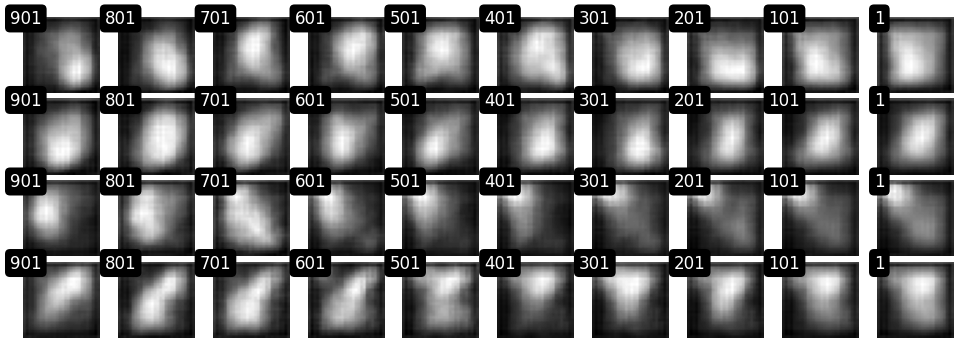

In [9]:
def show_sample2d(images, texts):   
    num_rows = len(images)
    num_cols = len(images[0]) if images else 0
    _, figs = plt.subplots(num_rows, num_cols, figsize=(12, 12))
    for i in range(num_rows):  
        for j in range(num_cols):  
            f, img, text= figs[i][j], images[i][j], texts[i][j]
            img = img.view(28, 28)
            f.imshow(img, cmap='gray')
            f.axis('off')
            f.text(0.5, 0.05, text, ha='center', va='center', fontsize=12,   
                   color='white', backgroundcolor='black', bbox=dict(facecolor='black', edgecolor='none', boxstyle='round'))  
    plt.subplots_adjust(wspace=0.24, hspace=-0.88)
    plt.show()
    
vae, u_net= torch.load(vae_save_path), torch.load(unet_save_path)
dm= DenoiseDiffusion(u_net, 1000, device= device)
from tqdm import tqdm
test_pic_num= 4
images, texts= [], []
for i in range(test_pic_num):
    images_, texts_= [], []
    print(f'sample {i+ 1} image, denoising...')
    xt= torch.randn((1, 4, 7, 7), device= device)
    for t in tqdm(reversed(range(1000))):
        xt_1= dm.p_sample(xt, torch.tensor([t]).to(device))
        xt= xt_1
        if (t+ 1)% 100== 1:
            denoising_pic= vae.decoder(xt)
            images_.append(denoising_pic.view(1, 28, 28).to('cpu').detach())
            texts_.append(t+ 1)
    images.append(images_)
    texts.append(texts_)
    
show_sample2d(images, texts)

__我不懂__